# Supervised Classification for GRS1915+105 Light curves

In this notebook, we'll do some supervised classification on light curves of GRS 1915+105.
Let's get started!

First, we need some features. The details of feature extraction are explained in the accompanying notebook `GRS1915_Feature_Extraction.ipynb`. Here, we'll assume you've worked your way through that, and are ready to work with a feature vector you've made in there.

Therefore, we'll just load said feature vector:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import sklearn
import pickle
import feature_extraction
import generaltools as gt

datadir = "/scratch/daniela/data/grs1915/"

/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


We'll load the features, labels and associated light curves and hardness ratios from the files we made in the feature extraction stage.

We need to use the features/light curves with the *longer* segment size (1024 seconds).
We'll also load the feature engineering results from the greedy search:

In [2]:
with open(datadir+"grs1915_greedysearch_res.dat" ,'r') as f:
    data = pickle.load(f)

In [3]:
scores = data["scores"]
ranking = data["ranking"]

In [4]:
np.array(ranking)+1

array([11, 10, 12,  3, 15, 31,  4, 13, 29, 32, 40,  7, 34, 28, 25,  6, 27,
       18, 21, 30, 17, 37, 24, 14,  9, 16, 26, 23, 35,  2, 20,  1, 41, 38,
        5, 36, 22,  8, 39, 33, 19])

In [5]:
max_scores = []
for s in scores:
    max_scores.append(np.max(s))

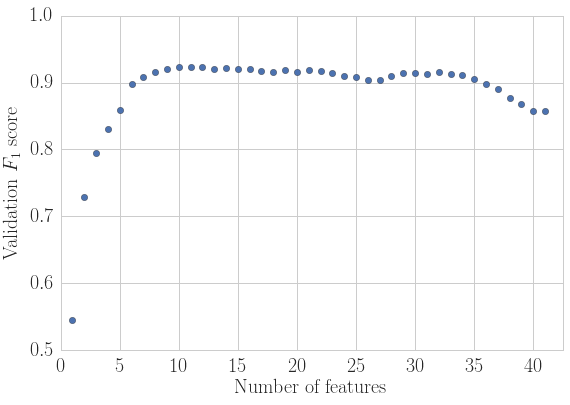

In [6]:
sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.scatter(np.arange(1,len(max_scores)+1,1), max_scores, marker="o", c=sns.color_palette()[0], s=40)
ax.set_xlabel("Number of features")
ax.set_ylabel("Validation $F_1$ score")
ax.set_xlim(0,len(max_scores)+1.5)
ax.set_ylim(0.5,1)
plt.savefig(datadir+"grs1915_feature_accuracy.pdf", format="pdf")


In [7]:
np.argmax(max_scores)

10

Now we can load the data itself:

In [8]:
from paper_figures import load_data

features, labels, lc, hr, tstart, nseg,\
    features_lb, labels_lb, lc_lb, hr_lb, nseg_lb, \
    fscaled, fscaled_lb, fscaled_full, labels_all = \
        load_data(datadir, tseg=1024.0, log_features=None)



Found outlier in training set.
after removal: []


In [9]:
labels_all_labelled = labels_all[labels_all != "None"]

In [10]:
labels_all_labelled = pd.Series(labels_all_labelled)

We are going to compute the classified label fractions, because they are going to be useful later.

In [11]:
labels_all_labelled.value_counts()

chi       762
theta     189
rho       157
gamma     151
beta      138
phi       106
kappa      95
mu         63
delta      55
eta        46
nu         42
lambda     35
alpha      28
omega      17
dtype: int64

In [12]:
classified_label_fractions = labels_all_labelled.value_counts()/np.sum(labels_all_labelled.value_counts())
classified_label_fractions

chi       0.404459
theta     0.100318
rho       0.083333
gamma     0.080149
beta      0.073248
phi       0.056263
kappa     0.050425
mu        0.033439
delta     0.029193
eta       0.024416
nu        0.022293
lambda    0.018577
alpha     0.014862
omega     0.009023
dtype: float64

In [13]:
features_train_full = features["train"]
features_val_full = features["val"]
features_test_full = features["test"]

ftrain_labelled = features_lb["train"]
fval_labelled = features_lb["val"]
ftest_labelled = features_lb["test"]

labels_train = labels_lb["train"]
labels_val =  labels_lb["val"]
labels_test = labels_lb["test"]


In [14]:
print(len(np.unique(labels_train)))
print(len(np.unique(labels_val)))
print(len(np.unique(labels_test)))

14
14
14


In [15]:
print(features_train_full.shape)
print(features_val_full.shape)
print(features_test_full.shape)

(4668, 41)
(2094, 41)
(2450, 41)


In [16]:
print(len(labels_train))
print(len(labels_val))
print(len(labels_test))

885
480
519


In [17]:
np.sum([len(labels_train), len(labels_val), len(labels_test)])

1884

We'll need the scaled versions for the learning:

In [18]:
fscaled_train = fscaled_lb["train"]
fscaled_val = fscaled_lb["val"]
fscaled_test = fscaled_lb["test"]

fscaled_train_full = fscaled["train"]
fscaled_val_full = fscaled["val"]
fscaled_test_full = fscaled["test"]

And finaly the full feature sets for various unsupervised things.

## Visualization

Let's start with some visualization.

We'll plot all features against all other features in simple scatter plots:

In [19]:
def scatter(f1_full, f2_full, labels, log1=False, log2=False, alpha=0.5, palette="Set3"):
    if log1:
        f1 = np.log(f1_full)
    else:
        f1 = f1_full
        
    if log2:
        f2 = np.log(f2_full)
    else:
        f2 = f2_full
        
    #f1_labelled = f1[labels != "None"]
    #f2_labelled = f2[labels != "None"]
    
    unique_labels = np.unique(labels)
    unique_labels = np.delete(unique_labels, np.where(unique_labels == "None")[0])
    #print("unique labels : " + str(unique_labels))
    
    # make a Figure object
    fig, ax = plt.subplots(1,1,figsize=(12,9))
    
    # first plot the unclassified examples:
    ax.scatter(f1[labels == "None"], f2[labels == "None"], color="grey", alpha=alpha)

    # now make a color palette:
    current_palette = sns.color_palette(palette, len(unique_labels))
    
    for l, c in zip(unique_labels, current_palette):
        ax.scatter(f1[labels == l], f2[labels == l], color=c, alpha=alpha, label=l)
        
    plt.legend()
    
    return fig, ax
    
    

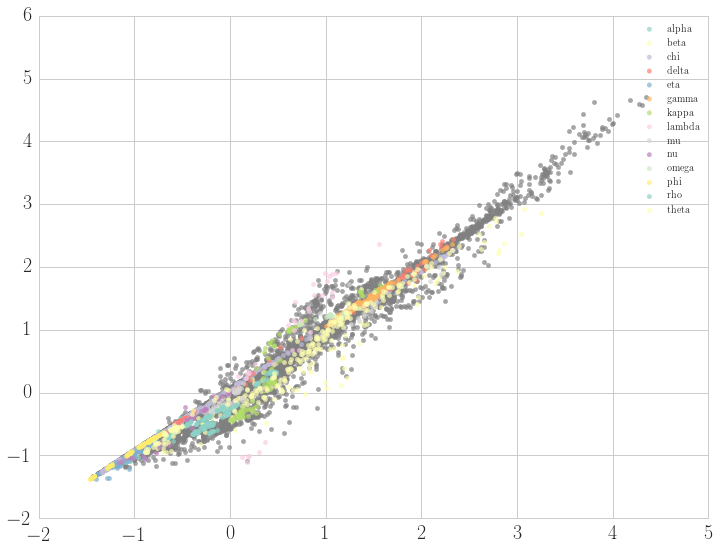

In [20]:
fig, ax = scatter(fscaled_full[:,0], fscaled_full[:,1], 
                  labels_all, log1=False, log2=False, alpha=0.7)

For classification, the following features should be log-scaled:
* total variance in the light curve (2)
* frequency of maximum power in the PSD (5)
* power spectral band A (6)
* power spectral band B (7)
* power spectral band D (9)
* PSD colour 1 (10)
* PSD colour 2 (11)
* variance of HR1 (14)
* variance of HR 2(16)

Let's do that, then. This is now implemented in the initial `load_data` function, so it doesn't need to be here.

What happens if I do a simple PCA decomposition of my features?

In [21]:
from sklearn.decomposition import PCA

fscaled_full = np.vstack([fscaled["train"], fscaled["val"], fscaled["test"]])

labels_all = np.hstack([labels["train"], labels["val"], labels["test"]])

In [22]:
pc = PCA(n_components=2)
fscaled_pca = pc.fit(fscaled_full).transform(fscaled_full)

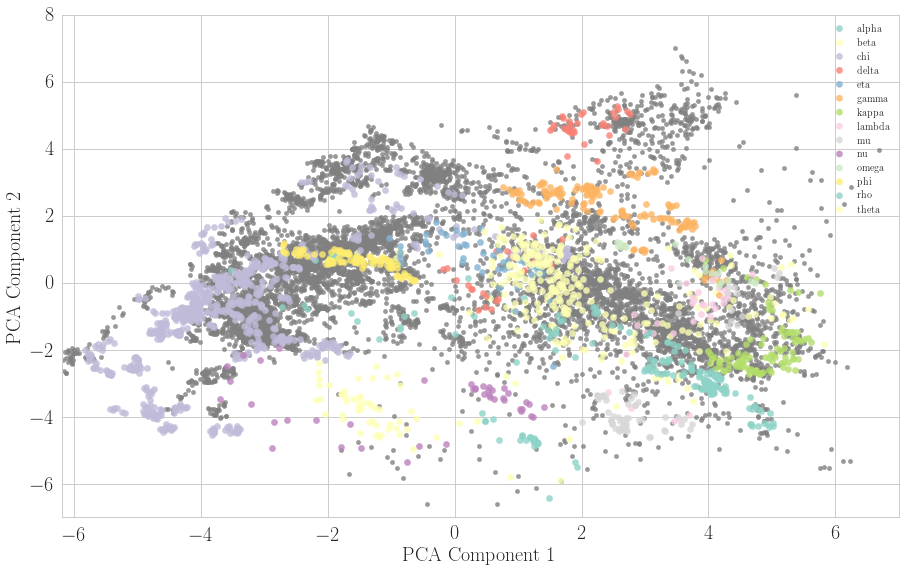

In [23]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

unique_labels = np.unique(labels_all)
unique_labels = np.delete(unique_labels, np.where(unique_labels == "None")[0])
#print("unique labels : " + str(unique_labels))

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_pca[labels_all == "None",0], fscaled_pca[labels_all == "None",1], color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax.scatter(fscaled_pca[labels_all == l,0], fscaled_pca[labels_all == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-6.2, 7.0)
plt.ylim(-7.0, 8.0)
plt.legend()


One thing I'd also like to do is think about the *physical* differences between classes. There are some indications that these differences are due to stochastic versus chaotic versus deterministic processes. 

From Misra (2006): 
* **Chaotic**: beta, lambda, kappa, mu
* **deterministic**: theta, rho, alpha, nu, delta
* **stochastic**: phi, gamma, chi

Where do omega and eta lie in this? It looks like they were not part of the analysis. Can we infer where they should lie? Let's separate labels into the three new classes, but leave eta and omega where they are, then visualize the results:

In [24]:
labels_train = labels["train"]
labels_val = labels["val"]
labels_test = labels["test"]

chaotic = ["beta", "lambda", "kappa", "mu"]
deterministic = ["theta", "rho", "alpha", "nu", "delta"]
stochastic = ["phi", "gamma", "chi"]

labels_train_phys, labels_val_phys, labels_test_phys = [], [], []
for l in labels_train:
    if l in chaotic:
        labels_train_phys.append("chaotic")
    elif l in deterministic:
        labels_train_phys.append("deterministic")
    elif l in stochastic:
        labels_train_phys.append("stochastic")
    else:
        labels_train_phys.append(l)
        
for l in labels_test:
    if l in chaotic:
        labels_test_phys.append("chaotic")
    elif l in deterministic:
        labels_test_phys.append("deterministic")
    elif l in stochastic:
        labels_test_phys.append("stochastic")
    else:
        labels_test_phys.append(l)

for l in labels_val:
    if l in chaotic:
        labels_val_phys.append("chaotic")
    elif l in deterministic:
        labels_val_phys.append("deterministic")
    elif l in stochastic:
        labels_val_phys.append("stochastic")
    else:
        labels_val_phys.append(l)

 

In [25]:
labels_all_phys = np.hstack([labels_train_phys, labels_val_phys, labels_test_phys])
labels_unique_phys = np.unique(labels_all_phys)
labels_unique_phys = np.delete(labels_unique_phys, 0)
print("unique labels: " + str(labels_unique_phys))



unique labels: ['chaotic' 'deterministic' 'eta' 'omega' 'stochastic']


In [26]:
labels_phys = {"train":labels_train_phys,
              "test": labels_test_phys,
              "val": labels_val_phys}

Now we can redo the visualization:

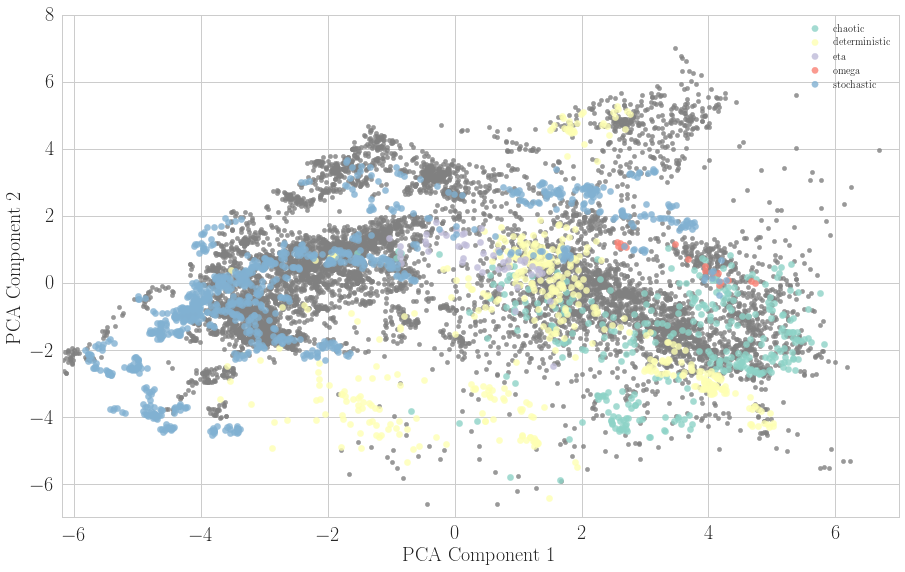

In [27]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_pca[labels_all_phys == "None",0], 
           fscaled_pca[labels_all_phys == "None",1], 
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(labels_unique_phys))

for l, c in zip(labels_unique_phys, current_palette):
    ax.scatter(fscaled_pca[labels_all_phys == l,0], 
               fscaled_pca[labels_all_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-6.2, 7.0)
plt.ylim(-7.0, 8.0)
plt.legend()



I think I want to make a Figure including both! I have a handy function to do the plot above in the plotting module:

In [28]:
import plotting

(-8, 8)

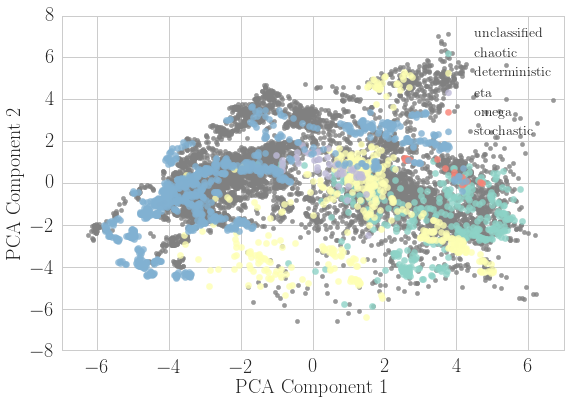

In [29]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax = plotting.scatter(fscaled_pca, labels_all_phys, ax=ax)
plt.xlim(-7, 7)
plt.ylim(-8, 8)

Now we can plot both together:

(-8, 8)

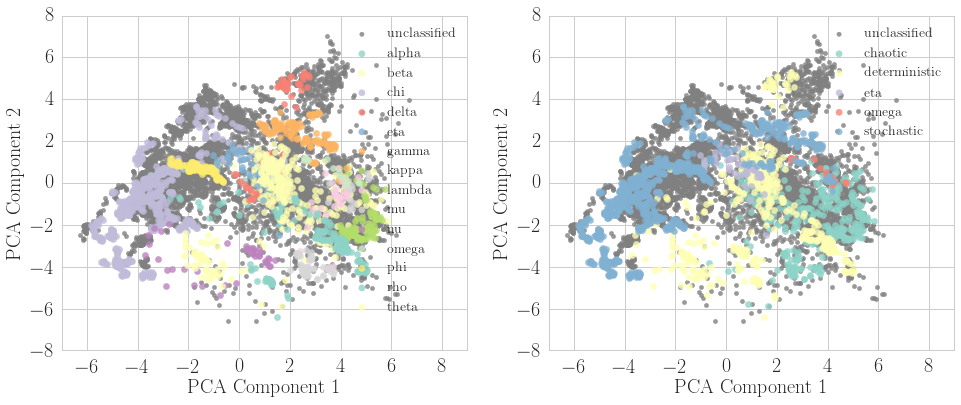

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ax1 = plotting.scatter(fscaled_pca, labels_all, ax=ax1)
ax2 = plotting.scatter(fscaled_pca, labels_all_phys, ax=ax2)
ax1.set_xlim(-7, 9)
ax1.set_ylim(-8, 8)
ax2.set_xlim(-7, 9)
ax2.set_ylim(-8, 8)

In [31]:
import paper_figures

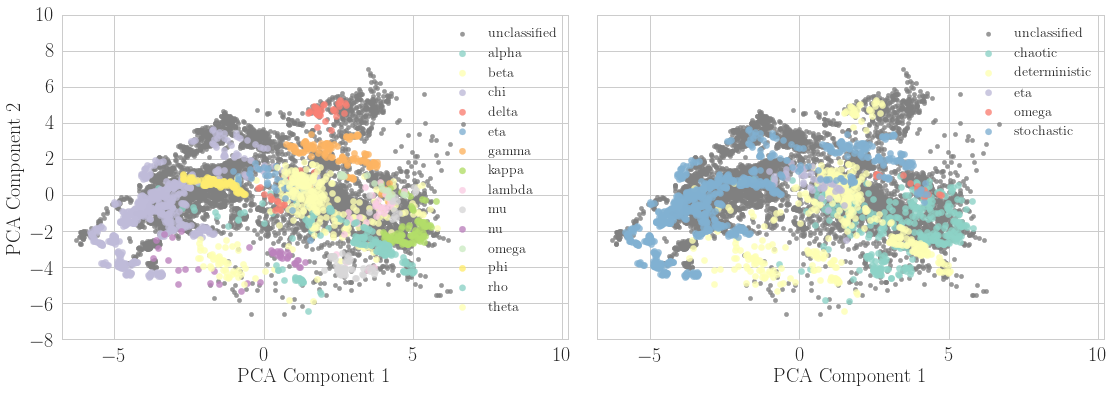

In [32]:
ax1, ax2 = paper_figures.features_pca(fscaled_full, labels, axes=None,
                 alpha=0.8, palette="Set3")

ax1.set_ylim(-8, 10)
ax2.set_ylim(-8, 10)

ax2.set_ylabel("")
plt.tight_layout()
plt.savefig(datadir+"grs1915_features_pca.pdf", format="pdf")

What about LDA?

In [33]:
from sklearn.lda import LDA

/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [ ]:
lda = LDA(solver='svd', shrinkage=None, priors=None, n_components=2, 
          store_covariance=False, tol=0.0001)

In [ ]:
fscaled_lda = lda.fit_transform(fscaled_full[:,:11], labels_all)

In [ ]:
alpha=0.8
palette = "Set3"

sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# make a Figure object
fig, ax = plt.subplots(1,1,figsize=(15,9))

# first plot the unclassified examples:
ax.scatter(fscaled_lda[labels_all_phys == "None",0], 
           fscaled_lda[labels_all_phys == "None",1], 
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(labels_unique_phys))

for l, c in zip(labels_unique_phys, current_palette):
    ax.scatter(fscaled_lda[labels_all_phys == l,0], 
               fscaled_lda[labels_all_phys == l,1], s=40,
               color=c, alpha=alpha, label=l)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-6.2, 7.0)
plt.ylim(-7.0, 8.0)
plt.legend()




Doesn't look so bad! Let's try t-SNE:

In [ ]:
from sklearn.manifold import TSNE
fscaled_tsne = TSNE(n_components=2).fit_transform(fscaled_full[:,:11])

In [ ]:
ax1, ax2 = paper_figures.features_pca(fscaled_full[:,:11], labels, 
                                      axes=None, algorithm="tsne",
                                      alpha=0.8, palette="Set3")


ax2.set_ylabel("")
plt.tight_layout()
plt.savefig(datadir+"grs1915_features_tsne.pdf", format="pdf")


## Classification

How about some classification?

First, let's get the **labelled** data out of their dictionaries:

In [34]:
fscaled_train = fscaled_lb["train"]
fscaled_test = fscaled_lb["test"]
fscaled_val = fscaled_lb["val"]

labels_train = labels_lb["train"]
labels_test = labels_lb["test"]
labels_val = labels_lb["val"]

Next, we're going to try the simplest algorithm we can: K-Nearest Neighbours.
We're going to cross-validate across some parameters (check documentation).

We're going to use only the first eleven features, since our cross validation identified those as the most predictive features.

In [35]:
fscaled_train.shape

(885, 41)

In [36]:
nfeatures = 10

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]}#, 'max_features': }
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, 
                    n_jobs=10, scoring="f1_macro")
grid.fit(fscaled_train[:,:nfeatures], labels_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_macro', verbose=1)

In [38]:
print(grid.best_params_)
print(grid.score(fscaled_train[:,:nfeatures], labels_train))
print(grid.score(fscaled_val[:,:nfeatures], labels_val))
print(grid.score(fscaled_test[:,:nfeatures], labels_test))


{'n_neighbors': 1}
1.0
0.727922236741
0.826452778274


/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Plain nearest neighbour search gets us to $\sim 80\%$! That's not great, but also not terrible! 

If the classes are clearly separated by hyperplanes, that is the problem is linear, we can use logistic regression or a linear SVM to model the data. We're going to use an L2 norm and balanced class weights to allow for probabilistic class estimates:

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [40]:
params_c =  [0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10.0, 20, 50, 100.0, 1000.0]

scores = np.zeros_like(params_c)
for i,c in enumerate(params_c):
    lr = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
                            C=c, solver="lbfgs")

    lr.fit(fscaled_train[:,:nfeatures], labels_train)
    scores[i] = lr.score(fscaled_val[:,:nfeatures], labels_val)


In [41]:
max_score = np.max(scores)
print(max_score)
max_ind = np.argmax(scores)
print(max_ind)
lr_max_c = params_c[max_ind]
print(lr_max_c)

0.872916666667
8
10.0


In [42]:
lr_best = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
                            C=lr_max_c, solver="lbfgs")

lr_best.fit(fscaled_train[:,:nfeatures], labels_train)


labels_lr = lr_best.predict(fscaled_val[:,:nfeatures])
labels_lr_test = lr_best.predict(fscaled_test[:,:nfeatures])

labels_lr_all = lr_best.predict(fscaled_full[:,:nfeatures])
print("Test data set: " + str(lr_best.score(fscaled_test[:,:nfeatures], labels_test)))

Test data set: 0.926782273603


(-10, 10)

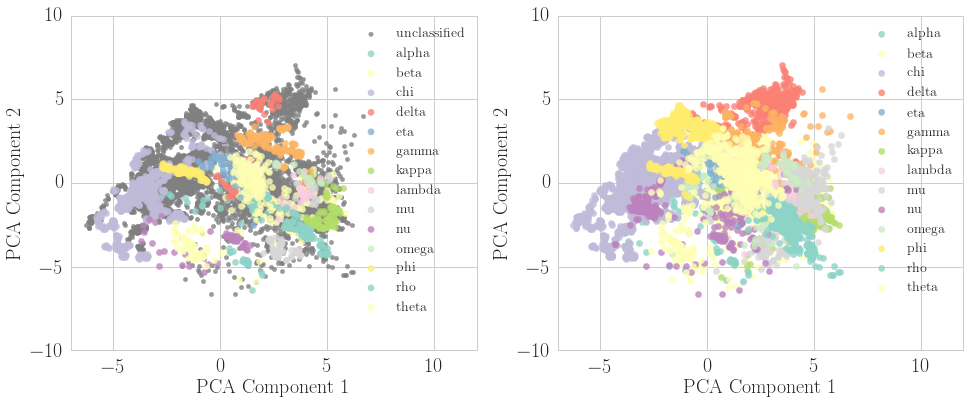

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ax1 = plotting.scatter(fscaled_pca, labels_all, ax=ax1)
ax2 = plotting.scatter(fscaled_pca, labels_lr_all, ax=ax2)
ax1.set_xlim(-7, 12)
ax1.set_ylim(-10, 10)
ax2.set_xlim(-7, 12)
ax2.set_ylim(-10, 10)

That does a pretty good job! Let's also try an SVM:

In [44]:
from sklearn.svm import LinearSVC

In [45]:
svm = sklearn.svm.LinearSVC(penalty="l2", loss="squared_hinge", dual=False,
                            class_weight="balanced", multi_class="ovr")

In [46]:
params_c =  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10.0, 20, 50, 100.0, 1000.0]

scores = np.zeros_like(params_c)
for i,c in enumerate(params_c):
    svm = sklearn.svm.LinearSVC(penalty="l2", loss="squared_hinge", dual=False,
                            class_weight="balanced", multi_class="ovr", C=c)

    svm.fit(fscaled_train[:,:nfeatures], labels_train)
    scores[i] = svm.score(fscaled_val[:,:nfeatures], labels_val)


In [47]:
max_score = np.max(scores)
print(max_score)
max_ind = np.where(scores == max_score)[0][0]
print(max_ind)
svm_max_c = params_c[max_ind]
print(svm_max_c)

0.870833333333
5
0.5


In [48]:
svm_best = sklearn.svm.LinearSVC(penalty="l2", loss="squared_hinge", dual=False,
                        class_weight="balanced", multi_class="ovr", C=svm_max_c)

svm_best.fit(fscaled_train[:,:nfeatures], labels_train)

labels_svm = svm_best.predict(fscaled_val[:,:nfeatures])
labels_svm_test = svm_best.predict(fscaled_test[:,:nfeatures])

labels_svm_all = svm_best.predict(fscaled_full[:,:nfeatures])
print("Test data set: " + str(svm_best.score(fscaled_test[:,:nfeatures], labels_test)))
print("Linear model versus SVM: " + str(svm_best.score(fscaled_full[:,:nfeatures], labels_lr_all)))

Test data set: 0.944123314066
Linear model versus SVM: 0.855840208424


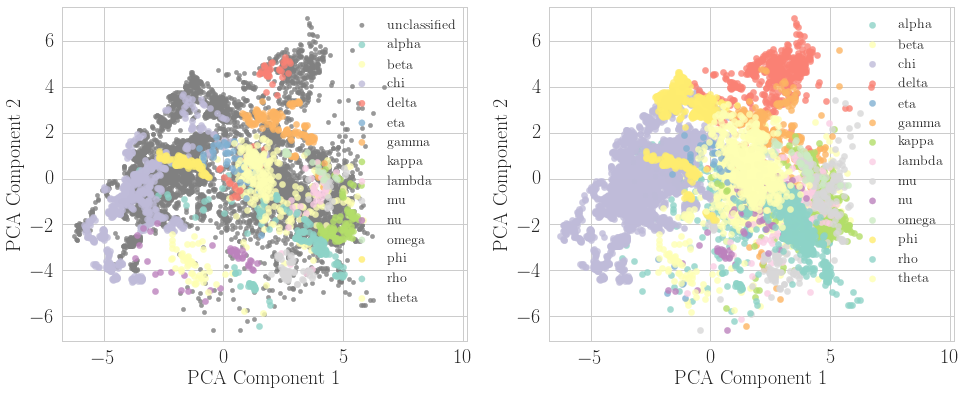

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ax1 = plotting.scatter(fscaled_pca, labels_all, ax=ax1)
ax2 = plotting.scatter(fscaled_pca, labels_svm_all, ax=ax2)


Let's try Random Forests, which are a lot more complex.

In [50]:
from sklearn.ensemble import RandomForestClassifier

params_max_depth = [7, 10, 20,40, 50, 100, 200, 500]
params_max_features = [2,4,6,8,10]

scores = np.zeros((len(params_max_depth), len(params_max_features)))

for i, md in enumerate(params_max_depth):
    for j, mf in enumerate(params_max_features):
        
        rfc = RandomForestClassifier(n_estimators=500, 
                                     max_features=mf, 
                                     max_depth=md)
        
        rfc.fit(fscaled_train[:,:nfeatures], labels_train)

        scores[i,j] = rfc.score(fscaled_val[:,:nfeatures], labels_val)
        

In [51]:
max_score = np.max(scores)
print(max_score)
max_ind = np.where(scores == max_score)

print(max_ind)

0.854166666667
(array([3]), array([2]))


In [52]:
print(max_ind)
rfc_best =  RandomForestClassifier(n_estimators=500, 
                              max_depth=params_max_depth[max_ind[0][0]], 
                              max_features=params_max_features[max_ind[1][0]])

rfc_best.fit(fscaled_train[:,:nfeatures], labels_train)

labels_rfc = rfc_best.predict(fscaled_val[:,:nfeatures])
labels_rfc_test = rfc_best.predict(fscaled_test[:,:nfeatures])

print("Test data set: " + str(rfc_best.score(fscaled_test[:,:nfeatures], labels_test)))

(array([3]), array([2]))
Test data set: 0.917148362235


It looks like Random Forests do no better than the simple linear model, so we might as well stick with that! 
Before we do that, we'll have a look at the feature importances, though:


In [53]:
feature_names = np.array(["LC mean", "LC median", "LC variance", "LC skew", "LC kurtosis",
                         r"$\nu_{\mathrm{max}}$", "PSD A", "PSD B", "PSD C", "PSD D", "PC 1", "PC 2",
                         "HR1 mean", "HR2 mean", "HR1 variance", "HR covariance", "HR2 variance",
                         "HR1 skew", "HR2 skew", "HR1 kurtosis", "HR2 kurtosis",
                         "LM 1", "LM 2", "LM 3", "LM 4", "LM 5", "LM 6", "LM 7", "LM 8", "LM 9", "LM 10",
                         "PCA 1", "PCA 2", "PCA 3", "PCA 4", "PCA 5", "PCA 6", "PCA 7", "PCA 8", "PCA 9", "PCA 10"])
print(feature_names.shape)
feature_names_ranked = feature_names[ranking]


(41,)


In [54]:
feature_names_ranked

array(['PC 1', 'PSD D', 'PC 2', 'LC variance', 'HR1 variance', 'LM 10',
       'LC skew', 'HR1 mean', 'LM 8', 'PCA 1', 'PCA 9', 'PSD A', 'PCA 3',
       'LM 7', 'LM 4', '$\\nu_{\\mathrm{max}}$', 'LM 6', 'HR1 skew',
       'HR2 kurtosis', 'LM 9', 'HR2 variance', 'PCA 6', 'LM 3', 'HR2 mean',
       'PSD C', 'HR covariance', 'LM 5', 'LM 2', 'PCA 4', 'LC median',
       'HR1 kurtosis', 'LC mean', 'PCA 10', 'PCA 7', 'LC kurtosis',
       'PCA 5', 'LM 1', 'PSD B', 'PCA 8', 'PCA 2', 'HR2 skew'], 
      dtype='|S20')

In [55]:
importances = rfc_best.feature_importances_
std = np.std([rfc_best.feature_importances_ for tree in rfc_best.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]



In [56]:
# Print the feature ranking
print("Feature ranking:")

for f in range(fscaled_train[:,:nfeatures].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 2 (0.216838)
2. feature 6 (0.205828)
3. feature 8 (0.129292)
4. feature 7 (0.104741)
5. feature 9 (0.102130)
6. feature 3 (0.093654)
7. feature 0 (0.045804)
8. feature 1 (0.040594)
9. feature 4 (0.037880)
10. feature 5 (0.023239)


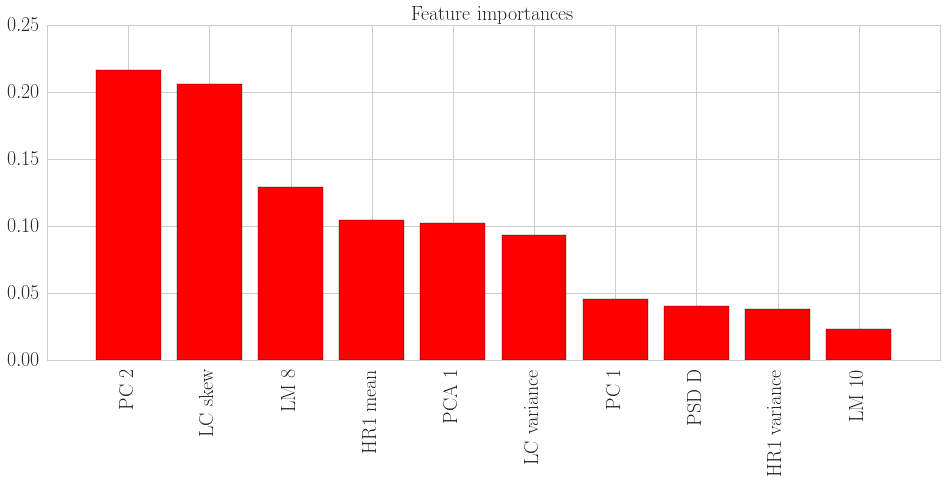

In [57]:
# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(fscaled_train[:,:nfeatures].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(fscaled_train.shape[1]), feature_names_ranked[:nfeatures][indices], rotation=90)
plt.xlim([-1, nfeatures])
plt.show()


### L1-based feature selection

Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with `feature_selection.SelectFromModel` to select the non-zero coefficients.

In [58]:
from sklearn.feature_selection import SelectFromModel

In [59]:
lr = LogisticRegression(C=lr_max_c, penalty="l1", class_weight=None, 
                        solver="liblinear")
lr.fit(fscaled_train, labels_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
model = SelectFromModel(lr, prefit=True)

In [61]:
fscaled_new = model.transform(fscaled_full)

In [62]:
fscaled_new.shape

(9212, 40)

Let's do the same with a Linear SVM:

In [63]:
svm = sklearn.svm.LinearSVC(penalty="l1", loss="squared_hinge",
                            class_weight=None, dual=False,
                           C=svm_max_c)

In [64]:
svm.fit(fscaled_train, labels_train)

LinearSVC(C=0.5, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [65]:
model = SelectFromModel(svm, prefit=True)

In [66]:
fscaled_new = model.transform(fscaled_full)
fscaled_new_train = model.transform(fscaled_train)
fscaled_new_val = model.transform(fscaled_val)
fscaled_new_test = model.transform(fscaled_test)

In [67]:
fscaled_new.shape

(9212, 39)

In [68]:
svm.fit(fscaled_new_train, labels_train)

LinearSVC(C=0.5, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
svm.score(fscaled_new_test, labels_test)

0.94412331406551064

In [70]:
fscaled_new_test.shape

(519, 39)

In [71]:
labels_val_svm = svm.predict(fscaled_new_val)

This is not helpful, so let's just continue with the best 17 labels:

In [72]:
features = {"train":features["train"][:,:nfeatures],
           "val": features["val"][:,:nfeatures],
            "test": features["test"][:,:nfeatures]}

features_lb = {"train": features_lb["train"][:,:nfeatures],
              "val": features_lb["val"][:,:nfeatures],
              "test": features_lb["test"][:,:nfeatures]}

features_all_full = np.vstack([features["train"], features["val"], features["test"]])
features_all_lb = np.vstack([features_lb["train"], features_lb["val"], features_lb["test"]])

In [73]:
import feature_engineering

In [74]:
fscaled, fscaled_lb = feature_engineering.scale_features(features, features_lb)

### Classification with the Linear Model

Let's redo the classification with the linear model one more time:

In [75]:
fscaled_train = fscaled_lb["train"]
fscaled_val = fscaled_lb["val"]
fscaled_test = fscaled_lb["test"]

fscaled_full = np.concatenate([fscaled["train"], fscaled["val"], fscaled["test"]])
fscaled_lb_full = np.concatenate([fscaled_train, fscaled_val, fscaled_test])

labels_train = labels_lb["train"]
labels_val = labels_lb["val"]
labels_test = labels_lb["test"]

In [76]:
lr = LogisticRegression(C=lr_max_c, penalty="l2", class_weight="balanced", multi_class="multinomial",
                        solver="lbfgs")
lr.fit(fscaled_train[:,:nfeatures], labels_train)

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [77]:
print(lr.score(fscaled_train[:,:nfeatures], labels_train))
print(lr.score(fscaled_val[:,:nfeatures], labels_val))

labels_lr_val = lr.predict(fscaled_val[:,:nfeatures])
labels_lr_test = lr.predict(fscaled_test[:,:nfeatures])

labels_lr_all = lr.predict(fscaled_full[:,:nfeatures])
print("Test data set: " + str(lr.score(fscaled_test[:,:nfeatures], 
                                       labels_test)))

0.987570621469
0.872916666667
Test data set: 0.926782273603


We also want the predicted probabilities:

In [78]:
proba_lr_val = lr.predict_proba(fscaled_val[:,:nfeatures])
proba_lr_test = lr.predict_proba(fscaled_test[:,:nfeatures])

In [79]:
lr.classes_

array(['alpha', 'beta', 'chi', 'delta', 'eta', 'gamma', 'kappa', 'lambda',
       'mu', 'nu', 'omega', 'phi', 'rho', 'theta'], 
      dtype='|S6')

In [80]:
proba_lr_test.shape

(519, 14)

We can plot a confusion matrix to look at which classes tend to be confused:

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', fig=None, ax=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if ax is None and fig is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], fontdict={"size":16},
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    return fig, ax


In [82]:
len(np.unique(labels_lr_test))

14

Confusion matrix, without normalization
[[ 16   1   1   0   1   0   0   0   0   5   0   0   1   0]
 [  1  68   1   0   0   0   2   0   1   0   0   0   0   3]
 [  0   0 344   0   0   0   0   0   0   1   0   0   0  22]
 [  0   1   0  19   5   0   2   0   0   1   4   0   0   0]
 [  0   0   0   1  27   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 103   0   0   0   1   1   0   0   0]
 [  0   3   0   0   0   0  34   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   4  15   1   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0  29   0   0   0   0   0]
 [  5   2   0   0   0   0   0   0   0  20   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0   0  63   0   0]
 [  0  11   0   0   0   0   0   0   0   0   0   0  63   0]
 [  0   9   0   0   0   0   0   0   0   0   0   0   0  95]]


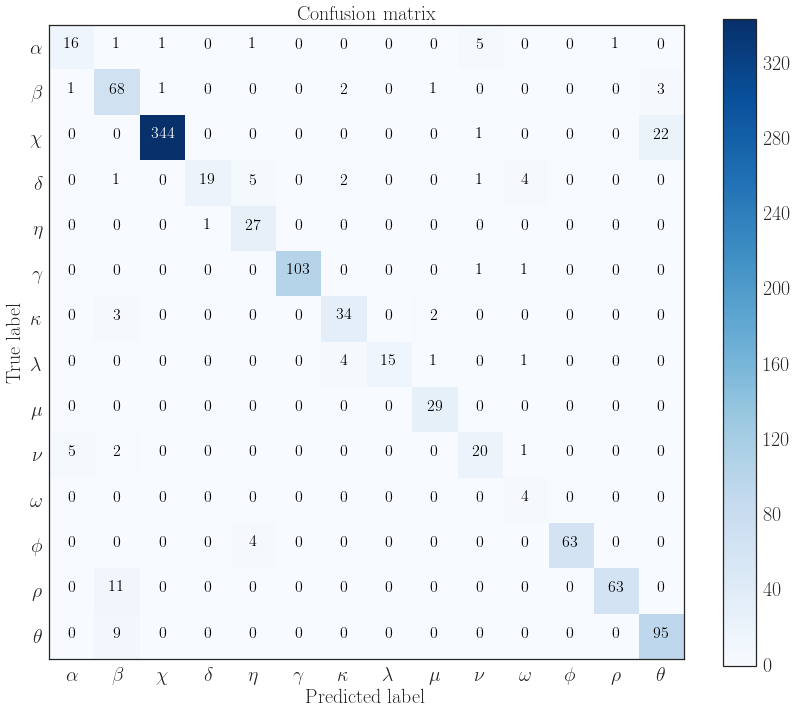

In [83]:
sns.set_style("white") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)


labels_for_plotting = [r"$\%s$"%l for l in lr.classes_]

cm = confusion_matrix(np.hstack([labels_val, labels_test]),
                      np.hstack([labels_lr_val, labels_lr_test]), labels=lr.classes_)
#cm = confusion_matrix(labels_val, labels_lr_val, labels=lr.classes_)



fig, ax  = plt.subplots(1,1, figsize=(12,10))
fig, ax = plot_confusion_matrix(cm, labels_for_plotting, fig=fig, ax=ax)



The classification is pretty good! ~90% are correctly identified. 
*


There are two possible explanations for these classifications:
1. There is some information in the data that our features do not capture
2. The human classification isn't perfect

In practice, it's probably a combination of both.

Let's make a Figure of publication:

In [84]:
reload(plotting)

<module 'plotting' from 'plotting.pyc'>

Confusion matrix, without normalization
[[ 16   1   1   0   1   0   0   0   0   5   0   0   1   0]
 [  1  68   1   0   0   0   2   0   1   0   0   0   0   3]
 [  0   0 344   0   0   0   0   0   0   1   0   0   0  22]
 [  0   1   0  19   5   0   2   0   0   1   4   0   0   0]
 [  0   0   0   1  27   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 103   0   0   0   1   1   0   0   0]
 [  0   3   0   0   0   0  34   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   4  15   1   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0  29   0   0   0   0   0]
 [  5   2   0   0   0   0   0   0   0  20   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0   0  63   0   0]
 [  0  11   0   0   0   0   0   0   0   0   0   0  63   0]
 [  0   9   0   0   0   0   0   0   0   0   0   0   0  95]]


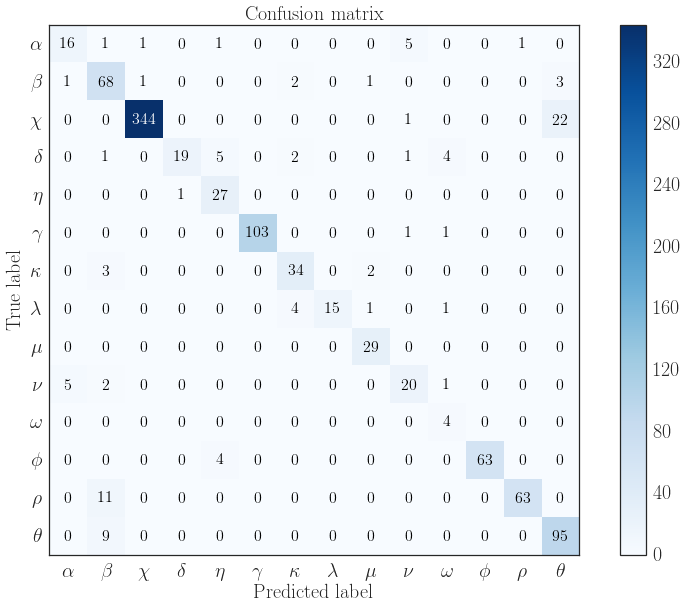

In [85]:
import matplotlib.cm as cmap
sns.set_style("white")
fig, ax = plt.subplots(1,1,figsize=(12,9))
ax = plotting.confusion_matrix(np.hstack([labels_val, labels_test]),
                      np.hstack([labels_lr_val, labels_lr_test]), 
                               labels_for_plotting, log=False, fig=fig, ax=ax,
                              cmap=cmap.Blues)
#fig.subplots_adjust(bottom=0.15, left=0.15)
plt.tight_layout()
plt.savefig("grs1915_supervised_cm.pdf", format="pdf")


One useful diagnostic is to plot all the light curves that are confused and see whether we can see a consistent behaviour. 

In [86]:
labels_all = np.hstack([labels_lb["train"], labels_lb["val"], labels_lb["test"]])
lc_all = np.concatenate([lc_lb["train"], lc_lb["val"], lc_lb["test"]])
hr_all = np.concatenate([hr_lb["train"], hr_lb["val"], hr_lb["test"]])

In [87]:
lc_train = lc_lb["train"]
lc_val = lc_lb["val"]
lc_test = lc_lb["test"]

hr_train = hr_lb["train"]
hr_val = hr_lb["val"]
hr_test = hr_lb["test"]

In [88]:
np.vstack([fscaled_val, fscaled_test])

array([[-0.93590862, -0.85649727, -0.91539125, ..., -0.17308483,
         0.68636547,  1.28218948],
       [-0.93089723, -0.85042682, -0.90471151, ..., -0.17876623,
         0.72516437,  1.25539803],
       [-0.92721856, -0.84663279, -0.90320597, ..., -0.12446226,
         0.70169844,  1.25230126],
       ..., 
       [-0.8413655 , -0.76240537, -1.38433863, ..., -0.73347331,
        -1.10976408, -0.8239202 ],
       [-0.84111401, -0.76088776, -1.40334088, ..., -0.84619409,
        -1.14422888, -0.8435604 ],
       [-0.84534683, -0.7654406 , -1.40155316, ..., -0.77304963,
        -1.11676185, -0.8690146 ]])

In [89]:
misclassifieds = []
for i,(f, lpredict, ltrue, proba, lc, hr) in enumerate(zip(np.vstack([fscaled_val, fscaled_test]),
                                                           np.hstack([labels_lr_val, labels_lr_test]), 
                                                           np.hstack([labels_val, labels_test]), 
                                                           np.vstack([proba_lr_val, proba_lr_test]),
                                                           np.concatenate([lc_val, lc_test]), 
                                                           np.concatenate([hr_val, hr_test]))):
    if lpredict == ltrue:
        continue
    else:
        misclassifieds.append([f, lpredict, ltrue, proba, lc, hr])

In [90]:
np.vstack([fscaled_val, fscaled_test]).shape

(999, 10)

In [91]:
len(misclassifieds)

99

In [92]:
proba_df = pd.DataFrame(np.vstack([proba_lr_val, proba_lr_test]), columns=lr.classes_)

In [93]:
max_proba = np.max(np.vstack([proba_lr_val, proba_lr_test]), axis=1)

In [94]:
for j,m in enumerate(misclassifieds):
    #pos_human = np.random.choice([0,3], p=[0.5, 0.5])
    #pos_robot = int(3. - pos_human)

    f = m[0]
    lpredict = m[1]
    ltrue = m[2]
    proba = m[3]
    times = m[4][0]
    counts = m[4][1]
    hr1 = m[5][0]
    hr2 = m[5][1]
    df = pd.DataFrame(proba, index=lr.classes_)
    print("Human classified class is: " + str(ltrue) + ", p = " + str(df.loc[ltrue].values))
    print("Predicted class is: " + str(lpredict) + ", p = " + str(df.loc[lpredict].values))

    print(df)
    print("============================================\n\n")

Human classified class is: nu, p = [ 0.39848228]
Predicted class is: alpha, p = [ 0.45732655]
                   0
alpha   4.573266e-01
beta    3.132683e-05
chi     1.285725e-01
delta   8.384139e-08
eta     2.009908e-03
gamma   2.422197e-05
kappa   7.665296e-09
lambda  2.472565e-08
mu      1.107263e-08
nu      3.984823e-01
omega   2.095200e-04
phi     1.431210e-05
rho     9.009133e-13
theta   1.332923e-02


Human classified class is: phi, p = [ 0.35465146]
Predicted class is: eta, p = [ 0.63875731]
                   0
alpha   3.407439e-03
beta    5.691045e-06
chi     9.144480e-04
delta   1.383422e-03
eta     6.387573e-01
gamma   6.765193e-04
kappa   1.360778e-07
lambda  1.324340e-09
mu      1.480193e-07
nu      8.851414e-05
omega   1.148071e-04
phi     3.546515e-01
rho     1.423641e-08
theta   9.723218e-08


Human classified class is: chi, p = [  7.17666958e-05]
Predicted class is: theta, p = [ 0.99929953]
                   0
alpha   2.804229e-17
beta    3.718031e-04
chi     7.176670

In [95]:
import scipy.stats 

def logbin_periodogram(freq, ps, percent=0.01):
    df = freq[1]-freq[0]
    minfreq = freq[0]*0.5
    maxfreq = freq[-1]
    binfreq = [minfreq, minfreq+df]
    while binfreq[-1] <= maxfreq:
        binfreq.append(binfreq[-1] + df*(1.+percent))
        df = binfreq[-1]-binfreq[-2]
    binps, bin_edges, binno = scipy.stats.binned_statistic(freq, ps, statistic="mean", bins=binfreq)
    #binfreq = np.logspace(np.log10(freq[0]), np.log10(freq[-1]+epsilon), bins, endpoint=True)
    #binps, bin_edges, binno = scipy.stats.binned_statistic(freq[1:], ps[1:], 
    #                                                       statistic="mean", bins=binfreq)
    #std_ps, bin_edges, binno = scipy.stats.binned_statistic(freq[1:], ps[1:], 
    #                                                       statistic=np.std, bins=binfreq)

    nsamples = np.array([len(binno[np.where(binno == i)[0]]) for i in xrange(np.max(binno))])
    df = np.diff(binfreq)
    binfreq = binfreq[:-1]+df/2.
    #return binfreq, binps, std_ps, nsamples
    return np.array(binfreq), np.array(binps), nsamples


In [96]:
import powerspectrum

def plot_misclassifieds(features, trained_labels, real_labels, proba_test, lc_test, hr_test, labels_all, 
                        lc_all, hr_all, nexamples=6, namestr="misclassified"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, proba, lc, hr) in enumerate(zip(features, trained_labels, real_labels, 
                                                               proba_test, lc_test, hr_test)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, proba, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        proba = m[3]
        times = m[4][0]
        counts = m[4][1]
        hr1 = m[5][0]
        hr2 = m[5][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lp, lc, hr] for lp, lc, hr in \
                     zip(labels_all, lc_all, hr_all)\
                     if lp == lpredict ]
        human_all = [[lp, lc, hr] for lp, lc, hr in \
                     zip(labels_all, lc_all, hr_all)\
                     if lp == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]
        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim([.27, 0.85])
            ax.set_ylim([0.04, 0.7])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            binfreq, binps, nsamples = logbin_periodogram(ps.freq[1:], ps.ps[1:])
            ax.loglog(binfreq, binps, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            plot_lcs(h[1][0], h[1][1], h[2][0], h[2][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[1][0], r[1][1], r[2][0], r[2][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        plt.savefig(namestr+"%i.pdf"%j, format="pdf")
        plt.close()

In [ ]:
plot_misclassifieds(np.vstack([fscaled_val, fscaled_test]),
                    np.hstack([labels_lr_val, labels_lr_test]), 
                    np.hstack([labels_val, labels_test]), 
                    np.vstack([proba_lr_val, proba_lr_test]),
                    np.concatenate([lc_val, lc_test]), 
                    np.concatenate([hr_val, hr_test]), 
                    labels_all, lc_all, hr_all, nexamples=102, namestr="../../misclassified")


## Classifying the entire data set

To compare with unsupervised methods, we're going to train on the entire supervised set, then use that to classify the unknown data points and plot a light curve.


### Human-classified Labels

Let's first start with the full 14 currently classified states:

In [97]:
fscaled_full = np.concatenate([fscaled["train"], fscaled["val"], fscaled["test"]])
fscaled_unclass = np.vstack([fscaled["train"][labels["train"] == "None"],
                                  fscaled["val"][labels["val"] == "None"],
                                  fscaled["test"][labels["test"] == "None"]
    ])

In [98]:
labels_cls = np.hstack([labels_lb["train"],
                        labels_lb["val"],
                        labels_lb["test"]])

labels_trained_unclass = lr.predict(fscaled_unclass[:,:nfeatures])
proba_unclass = lr.predict_proba(fscaled_unclass[:,:nfeatures])


In [99]:
proba_unclass = pd.DataFrame(proba_unclass, columns=lr.classes_, index=range(proba_unclass.shape[0]))

In [100]:
labels_trained_full = np.hstack([labels_cls,
                                 labels_trained_unclass])

Let's look at the distribution of states:

In [101]:
sns.set_style("whitegrid") 
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

st_human = pd.Series(labels_cls)
st_robot = pd.Series(labels_trained_unclass)
nstates_human = st_human.value_counts()
nstates_human /= np.sum(nstates_human.values)

nstates_robot = st_robot.value_counts()
nstates_robot /= np.sum(nstates_robot.values)

nstates_df = pd.concat([nstates_human, nstates_robot], axis=1)
nstates_df.columns = ["human", "computer"]
nstates_df

,human,computer
alpha,0.014862,0.015011
beta,0.073248,0.165257
chi,0.404459,0.405704
delta,0.029193,0.051719
eta,0.024416,0.003684
gamma,0.080149,0.016648
kappa,0.050425,0.033979
lambda,0.018577,0.009007
mu,0.033439,0.042167
nu,0.022293,0.036026


State durations should really be in seconds. Which means I need to account for overlap.

In [102]:
tstart_cls = np.hstack([tstart["train"][labels["train"] != "None"],
                        tstart["val"][labels["val"] != "None"],
                        tstart["test"][labels["test"] != "None"],])

tstart_unclass = np.hstack([tstart["train"][labels["train"] == "None"],
                        tstart["val"][labels["val"] == "None"],
                        tstart["test"][labels["test"] == "None"],])

In [103]:
np.max(tstart_cls)

289641902.06640625

In [104]:
np.max(tstart_unclass)

568003840.0625

If the starting point of the current segment is shifted only by 256 seconds from the previous one, then add only those 256 seconds, because this is the only part of the whole segment that's new; the rest overlaps with the previous segment. If the starting point is shifted by any other number, then the segment belongs to a new observation, and we add all 1024 seconds of the segment to our budget.

In [105]:
duration_cls = pd.Series(np.zeros(len(lr.classes_)), index=lr.classes_)
duration_unclass = pd.Series(np.zeros(len(lr.classes_)), index=lr.classes_)

In [106]:
for i,(l, ts) in enumerate(zip(labels_cls, tstart_cls)):
    if i == 0:
        duration_cls.loc[l] += 1024.
    else:
        dt = ts - tstart_cls[i-1]
        if np.isclose(dt, 256.0, rtol=0.1, atol=0.1):
            duration_cls.loc[l] += 256.
        else:
            duration_cls.loc[l] += 1024.



In [107]:
for i,(l, ts) in enumerate(zip(labels_trained_unclass, tstart_unclass)):
    if i == 0:
        duration_unclass.loc[l] += 1024.
    else:
        dt = ts - tstart_unclass[i-1]
        if np.isclose(dt, 256.0, rtol=0.1, atol=0.1):
            duration_unclass.loc[l] += 256.
        else:
            duration_unclass.loc[l] += 1024.




In [130]:

durations_df = pd.concat([duration_cls, duration_unclass], axis=1)
durations_df.columns = ["human", "computer"]
labels_for_plotting = [r"$\%s$"%u for u in unique_labels]
durations_df.index = labels_for_plotting

In [131]:
durations_df

,human,computer
$\alpha$,11776.0,50432.0
$\beta$,56832.0,500480.0
$\chi$,300288.0,1257216.0
$\delta$,27904.0,159232.0
$\eta$,16384.0,9216.0
$\gamma$,59392.0,54272.0
$\kappa$,42752.0,95232.0
$\lambda$,14336.0,26880.0
$\mu$,24576.0,123648.0
$\nu$,18432.0,111360.0


In [132]:
durations_df /= durations_df.sum()

In [133]:
durations_sorted = durations_df.sort_values("human", ascending=False,)

In [134]:
import matplotlib.cm as cmap

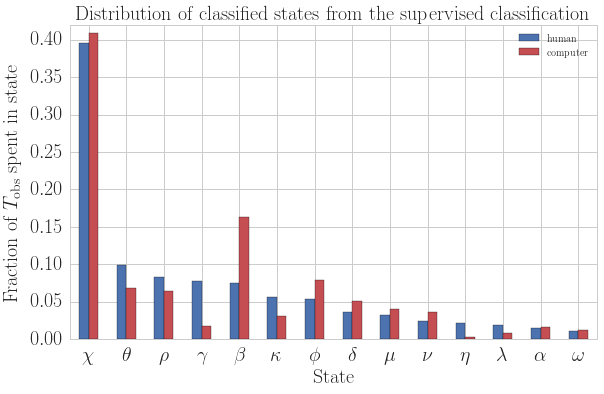

In [138]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
durations_sorted.plot(kind="bar", ax=ax, color=[sns.color_palette()[0], 
                                          sns.color_palette()[2]])

ax.set_ylim(0, np.max(durations_sorted.max())+0.01)
ax.set_title("Distribution of classified states from the supervised classification")
ax.set_xlabel("State")
ax.set_ylabel(r"Fraction of $T_\mathrm{obs}$ spent in state")
ax.set_xticklabels(durations_sorted.index, rotation=0)
plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_states_histogram.pdf", format="pdf")
#plt.close()



### State Probabilities in Detail

For $\beta$ and $\phi$, the classes that increased their fractional duration, what is the class with the second-highest probability and what are their probabilities?


#### Beta

We start by getting all machine-classified cases where beta has the highest probability.

In [139]:
proba_beta = proba_unclass.loc[labels_trained_unclass == "beta"]

Now we find the probability of the chosen class, as well as the probability of the second-highest probability and the class that second-highest probability belongs to:

In [140]:
beta_second_class = np.array([proba_beta.loc[i].sort_values(ascending=False).index[1] for i in proba_beta.index])
beta_first_class_proba = np.array([proba_beta.loc[i].sort_values(ascending=False).loc[proba_beta.loc[i].sort_values(ascending=False).index[0]] for i in proba_beta.index])
beta_second_class_proba = np.array([proba_beta.loc[i].sort_values(ascending=False).loc[proba_beta.loc[i].sort_values(ascending=False).index[1]] for i in proba_beta.index])


For how many cases is the probability of $\eta$ being the correct class > 80%?

In [141]:
len(beta_first_class_proba[beta_first_class_proba>0.8])/np.float(len(beta_first_class_proba))

0.5928984310487201

Let's plot a histogram to see the distribution of probabilities for the highest-scored class

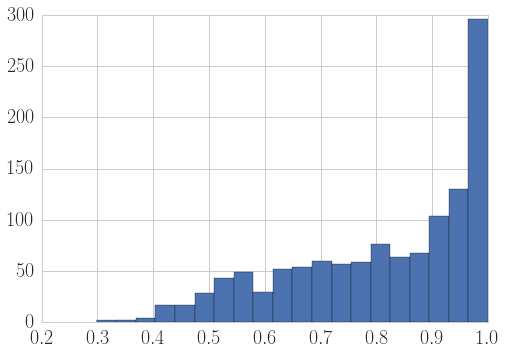

In [142]:
plt.hist(beta_first_class_proba, bins=20);

We're going to compute the ratio of the probability of class $\eta$ and the second-highest probability, then find all cases where that ratio is larger than 2. This means that being classified as $\eta$ is at least twice as probable as being classified in the second highest class:

In [143]:
log_ratio = np.log10(beta_first_class_proba/beta_second_class_proba)
frac_twice = len(log_ratio[log_ratio>np.log10(2)])/np.float(len(log_ratio))
print("For a fraction of %.4f cases, the probability for beta"%frac_twice + 
      " is twice as large as the second-highest probability.")


For a fraction of 0.8299 cases, the probability for beta is twice as large as the second-highest probability.


Let's also look at the second highest class: what's the probability of the segment belonging to the second highest class instead? We're going to look at the fraction of segments where that probability is < 20%:

In [144]:
len(beta_second_class_proba[beta_second_class_proba<0.2])/np.float(len(beta_second_class_proba))

0.6862097440132122

Finally, let's also look at the distribution of second-highest states:

In [145]:
beta_df = pd.DataFrame({"state": beta_second_class, "proba":beta_second_class_proba,
                      "log ratio":log_ratio})

In [146]:
beta_df["state"].value_counts()

theta     574
rho       224
lambda    126
nu        118
mu         77
kappa      38
alpha      20
delta      17
gamma      11
eta         4
omega       2
Name: state, dtype: int64

In [147]:
(16+4+4+1)/np.float(beta_df["state"].value_counts().sum())

0.02064409578860446

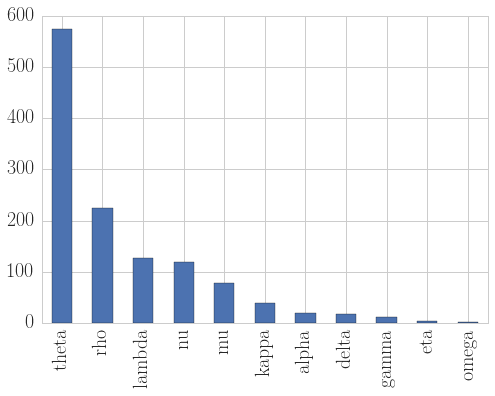

In [148]:
beta_df["state"].value_counts().plot("bar")

What are the probabilities for each of those states? Are there states that are more confused than others?

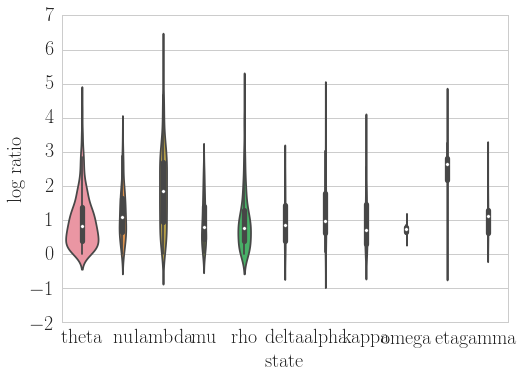

In [149]:
sns.violinplot("state", "log ratio", data=beta_df, scale="count");

In [169]:
27./(27+68)

0.28421052631578947

I'm going to make a function for all of this stuff:

In [150]:
def state_analysis(proba_unclass, lb, labels):
    proba= proba_unclass.loc[labels == lb]
    second_class = np.array([proba.loc[i].sort_values(ascending=False).index[1] for i in proba.index])
    first_class_proba = np.array([proba.loc[i].sort_values(ascending=False).loc[proba.loc[i].sort_values(ascending=False).index[0]] for i in proba.index])
    second_class_proba = np.array([proba.loc[i].sort_values(ascending=False).loc[proba.loc[i].sort_values(ascending=False).index[1]] for i in proba.index])

    print("There are %i observations in state %s."%(len(proba), lb))
    
    n_fc = len(first_class_proba[first_class_proba>0.8])/np.float(len(first_class_proba))
    print("The fraction of %s observations with probability >0.8 is %.4f"%(lb, n_fc))
    
    n_sc = len(second_class_proba[second_class_proba<0.2])/np.float(len(second_class_proba))
    print("The fraction of observations with probability <0.2 in the second-most probably class is %.4f"%n_sc)

    log_ratio = np.log(first_class_proba/second_class_proba)
    frac_twice = len(log_ratio[log_ratio>np.log(2)])/np.float(len(log_ratio))
    print("For a fraction of %.4f cases, the probability for %s"%(frac_twice, lb) + 
          " is twice as large as the second-highest probability.")
    
    fig, ax1 = plt.subplots(1,1,figsize=(9,6))
    _,_,_ = ax1.hist(first_class_proba, bins=20)
    
    state_df = pd.DataFrame({"state": second_class, "proba": second_class_proba,
                        "log ratio":log_ratio})

    fig, ax2 = plt.subplots(1,1,figsize=(9,6))
    state_df["state"].value_counts().plot("bar", ax=ax2)
    
    
    fig, ax3 = plt.subplots(1,1,figsize=(16,6))
    sns.violinplot("state", "log ratio", data=state_df, ax=ax3, scale="count");
    ax3.hlines(np.log(2.0), -1.0, 10.0)
    ax3.hlines(np.log(2.0), -1.0, 10.0)

    return


There are 576 observations in state phi.
The fraction of phi observations with probability >0.8 is 0.9444
The fraction of observations with probability <0.2 in the second-most probably class is 0.9583
For a fraction of 0.9844 cases, the probability for phi is twice as large as the second-highest probability.


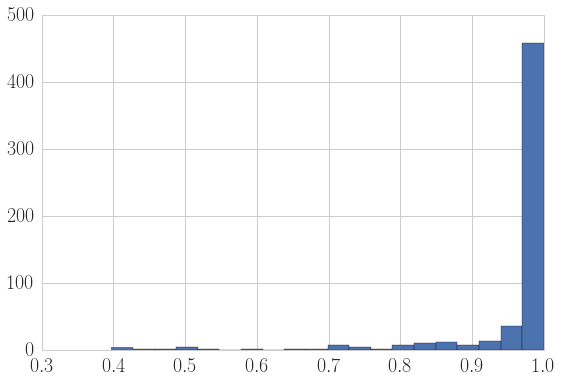

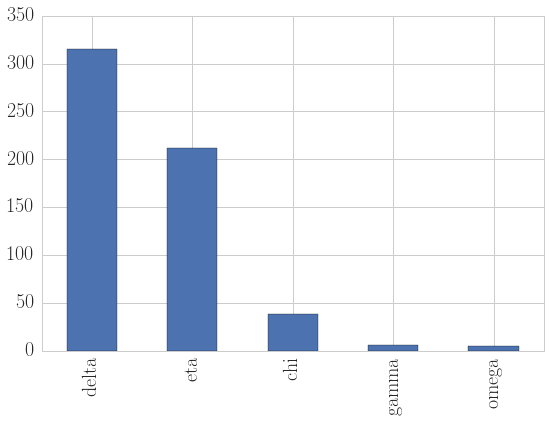

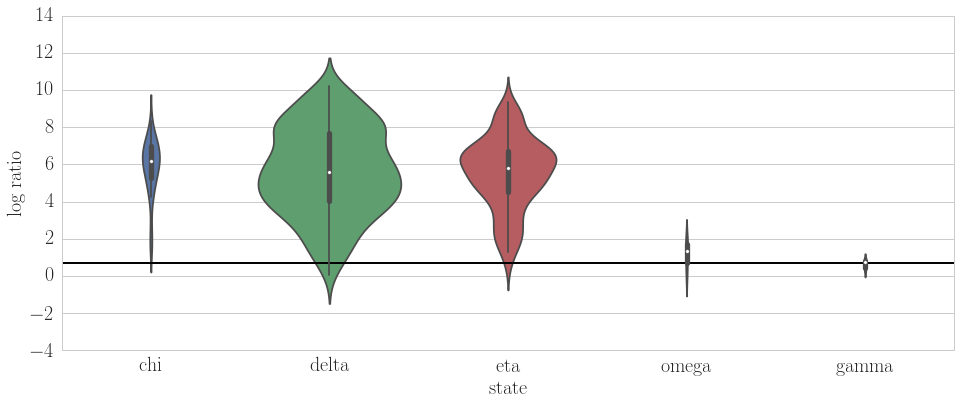

In [151]:
state_analysis(proba_unclass, "phi", labels_trained_unclass)

What about the states with much fewer examples? Where did those go?

In [152]:
def state_analysis_reverse(proba_unclass, lb, labels):
    #proba = proba_unclass.loc[labels == lb]
    idx = np.array([i for i in proba_unclass.index if proba_unclass.loc[i].sort_values(ascending=False).index[1] == lb])
    first_class = np.array([proba_unclass.loc[i].sort_values(ascending=False).index[0] for i in idx])
    second_class = np.array([proba_unclass.loc[i].sort_values(ascending=False).index[1] for i in idx])

    first_class_proba = np.array([proba_unclass.loc[i, proba_unclass.loc[i].sort_values(ascending=False).index[0]] for i in idx])
    second_class_proba = np.array([proba_unclass.loc[i, lb] for i in idx])

    print("There are %i observations in state %s."%(len(first_class_proba), lb))
    
    n_fc = len(first_class_proba[first_class_proba>0.8])/np.float(len(first_class_proba))
    print("The fraction of %s observations with probability >0.8 is %.4f"%(lb, n_fc))
    
    n_sc = len(second_class_proba[second_class_proba<0.2])/np.float(len(second_class_proba))
    print("The fraction of observations with probability <0.2 in the second-most probably class is %.4f"%n_sc)

    log_ratio = np.log(first_class_proba/second_class_proba)
    frac_twice = len(log_ratio[log_ratio>np.log(2)])/np.float(len(log_ratio))
    print("For a fraction of %.4f cases, the probability for %s"%(frac_twice, lb) + 
          " is twice as large as the second-highest probability.")
    
    fig, ax1 = plt.subplots(1,1,figsize=(9,6))
    _,_,_ = ax1.hist(first_class_proba, bins=20)
    
    state_df = pd.DataFrame({"state": first_class, "proba": second_class_proba,
                        "log ratio":log_ratio})

    fig, ax2 = plt.subplots(1,1,figsize=(9,6))
    state_df["state"].value_counts().plot("bar", ax=ax2)
    
    
    fig, ax3 = plt.subplots(1,1,figsize=(16,6))
    sns.violinplot("state", "log ratio", data=state_df, ax=ax3, scale="count");
    ax3.hlines(np.log(2.0), -1.0, 10.0)
    ax3.hlines(np.log(2.0), -1.0, 10.0)

    return




In [153]:
len(proba_unclass)

7328

There are 777 observations in state gamma.
The fraction of gamma observations with probability >0.8 is 0.8996
The fraction of observations with probability <0.2 in the second-most probably class is 0.9151
For a fraction of 0.9588 cases, the probability for gamma is twice as large as the second-highest probability.


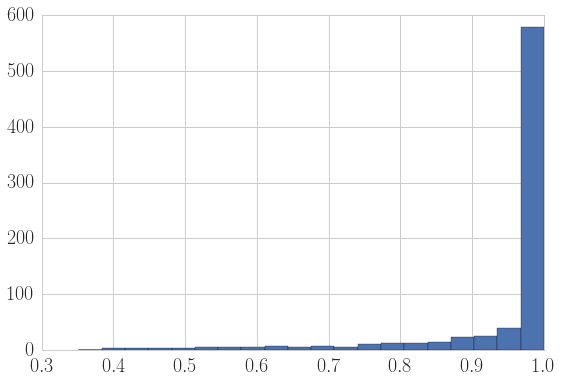

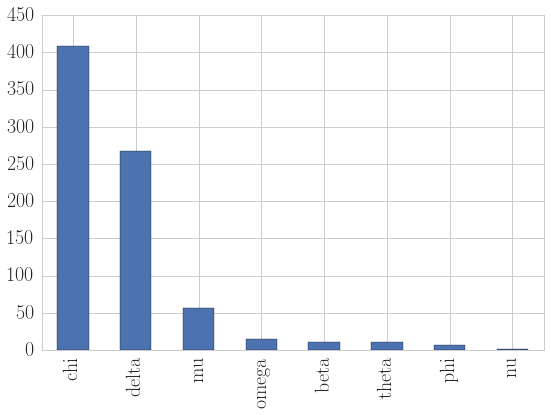

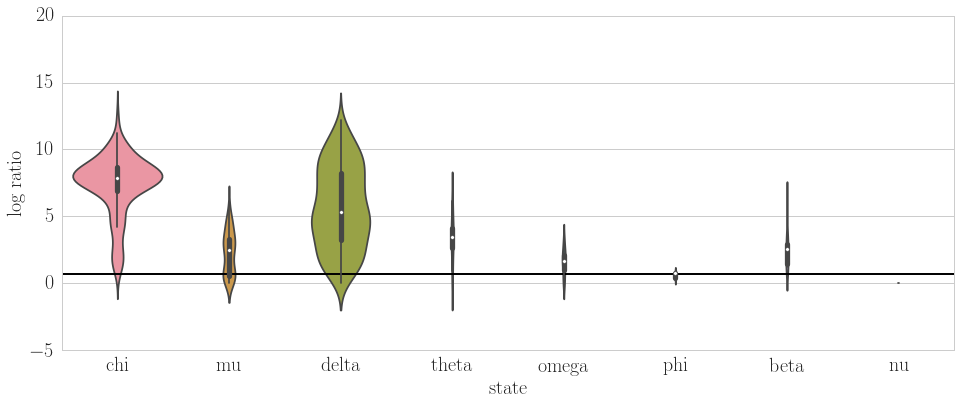

In [154]:
state_analysis_reverse(proba_unclass, "gamma", labels_trained_unclass)

Let's do the same for the $\kappa$ class, which has lost a lot of members, too:

There are 200 observations in state kappa.
The fraction of kappa observations with probability >0.8 is 0.4150
The fraction of observations with probability <0.2 in the second-most probably class is 0.5400
For a fraction of 0.7100 cases, the probability for kappa is twice as large as the second-highest probability.


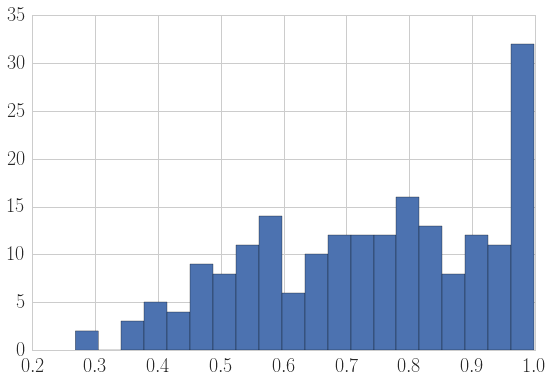

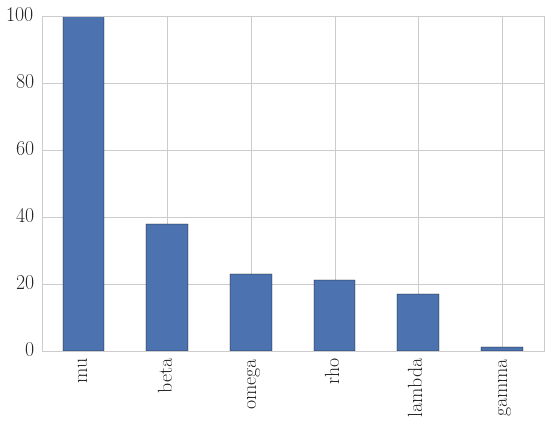

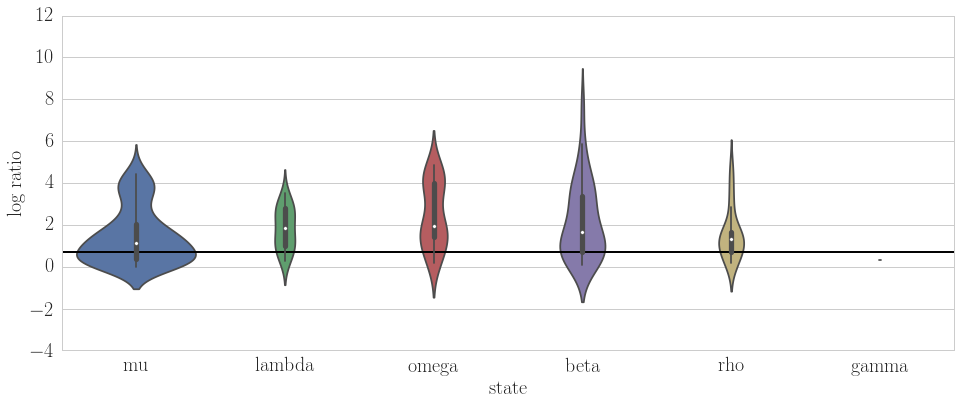

In [155]:
state_analysis_reverse(proba_unclass, "kappa", labels_trained_unclass)

Finally, we've also seen a decrease in class $\eta$:

There are 259 observations in state eta.
The fraction of eta observations with probability >0.8 is 0.8996
The fraction of observations with probability <0.2 in the second-most probably class is 0.9344
For a fraction of 0.9730 cases, the probability for eta is twice as large as the second-highest probability.


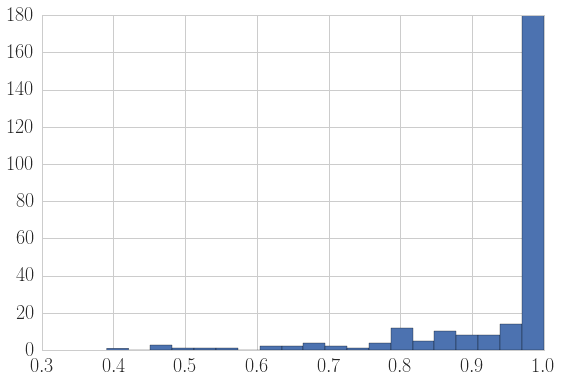

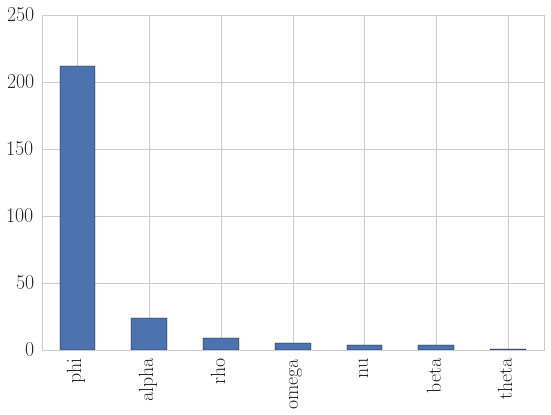

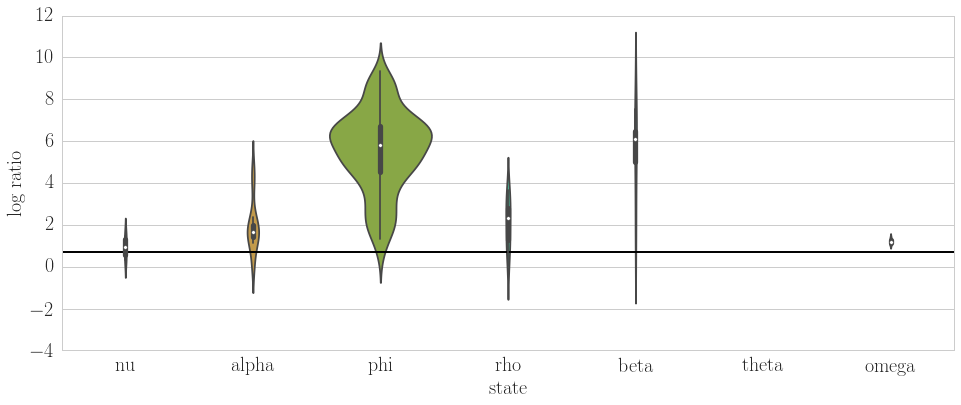

In [156]:
state_analysis_reverse(proba_unclass, "eta", labels_trained_unclass)

Let's redo the PCA Figure with the human versus machine classification:

In [157]:
labels_all = np.hstack([labels["train"], labels["val"], labels["test"]])

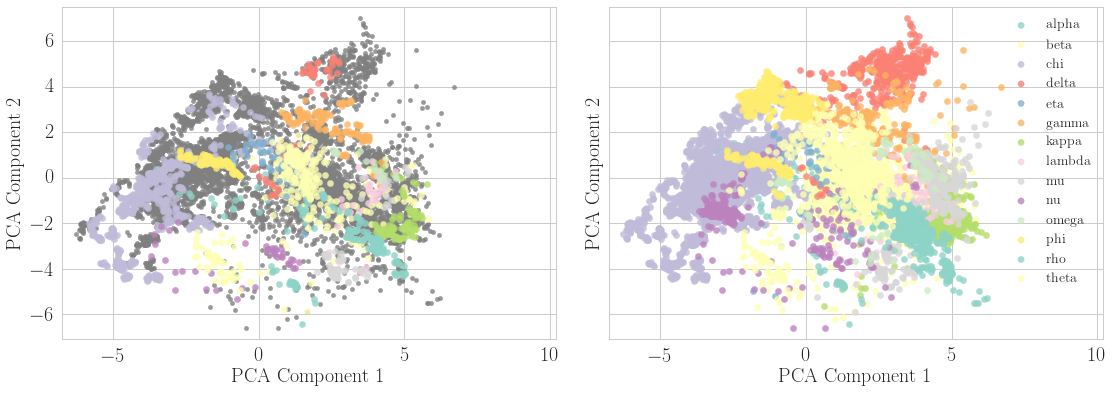

In [158]:
sns.set_style("whitegrid")
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20)
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

unique_labels = np.unique(labels_all)
unique_labels = np.delete(unique_labels,
                          np.where(unique_labels == "None")[0])

# make a Figure object
fig, axes = plt.subplots(1,2,figsize=(16,6), sharey=True)

xlim = [np.min(fscaled_pca[:,0])-0.5, np.max(fscaled_pca[:,0])+3.5] # [-6.2, 8.0]
ylim = [np.min(fscaled_pca[:,1])-0.5, np.max(fscaled_pca[:,1])+0.5] # [-7.0, 8.0]
ax1, ax2 = axes[0], axes[1]

# first plot the unclassified examples:
ax1.scatter(fscaled_pca[labels_all == "None",0],
           fscaled_pca[labels_all == "None",1],
           color="grey", alpha=alpha)

# now make a color palette:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax1.scatter(fscaled_pca[labels_all == l,0],
               fscaled_pca[labels_all == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax1.set_xlabel("PCA Component 1")
ax1.set_ylabel("PCA Component 2")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
#ax1.legend(loc="upper right", prop={"size":14})

fscaled_pca_plot = np.vstack([fscaled_pca[labels_all != "None"], 
                              fscaled_pca[labels_all == "None"]])

labels_plot = np.hstack([labels_cls, labels_trained_unclass])

# first plot the unclassified examples:
current_palette = sns.color_palette(palette, len(unique_labels))

for l, c in zip(unique_labels, current_palette):
    ax2.scatter(fscaled_pca_plot[labels_plot == l,0],
               fscaled_pca_plot[labels_plot == l,1], s=40,
               color=c, alpha=alpha, label=l)

ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend(loc="upper right", prop={"size":14})

plt.savefig(datadir+"grs1915_supervised_pca_comparison.pdf", format="pdf")
plt.tight_layout()


Let's look what the states look like over time.

In [159]:
labels_trained_all = np.zeros_like(labels_plot)

labels_trained_all[labels_all != "None"] = labels_cls
labels_trained_all[labels_all == "None"] = labels_trained_unclass

In [160]:
colors = sns.color_palette("Set3", 14)
unique_labels = np.unique(labels_trained_all)
print(unique_labels)
tstart_all = np.concatenate([tstart["train"], tstart["val"], tstart["test"]])

['alpha' 'beta' 'chi' 'delta' 'eta' 'gamma' 'kappa' 'lambda' 'mu' 'nu'
 'omega' 'phi' 'rho' 'theta']


In [161]:
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)
asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)

mjdrefi = 49353. 
tstart_all_days = tstart_all/(60.*60.*24.)
tstart_all_mjd = tstart_all_days + mjdrefi



The ASM light curve covers a total of 5725 days


<IPython.core.display.Javascript object>


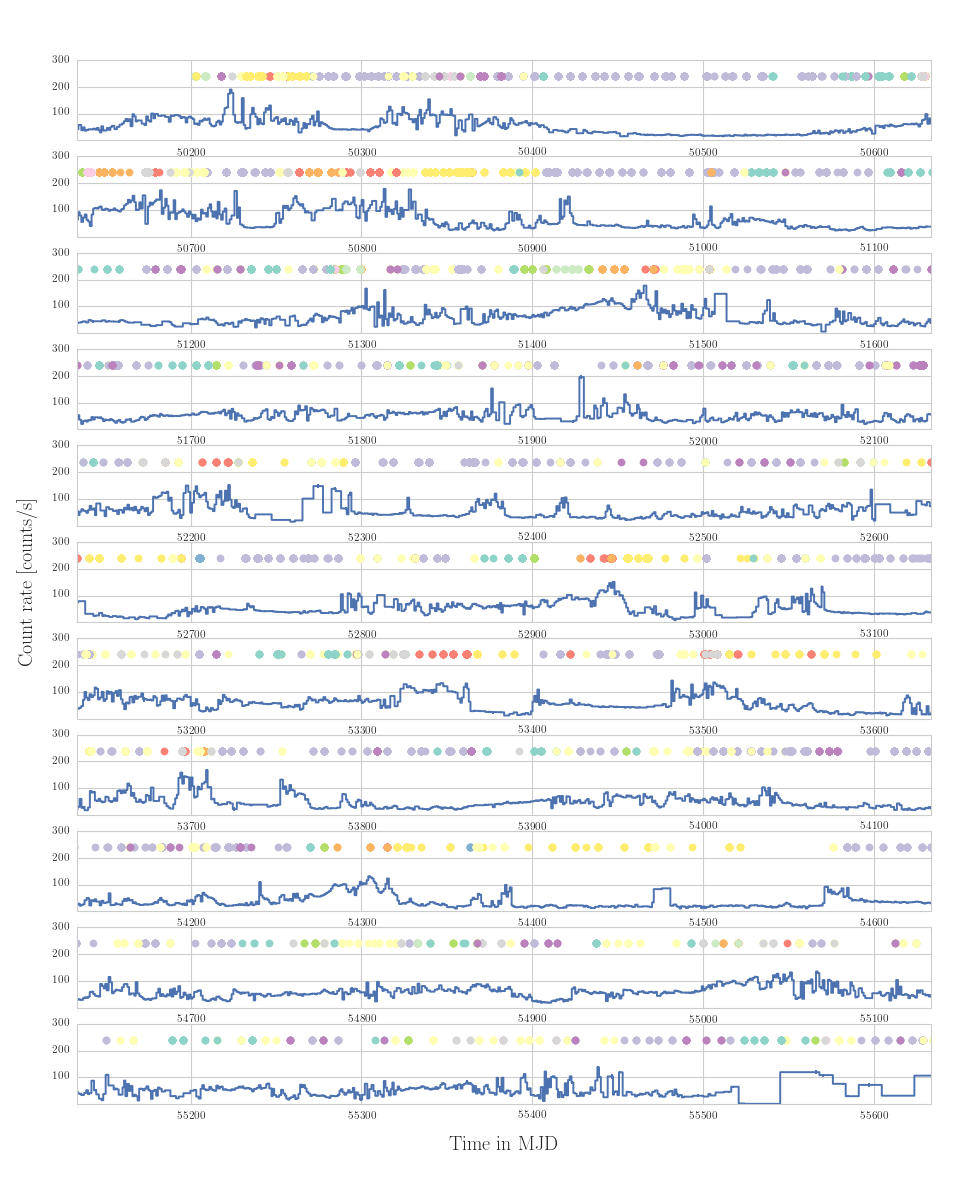

I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


In [162]:
%matplotlib notebook
## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("whitegrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette(palette, len(unique_labels))
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    for k, col in zip(unique_labels, colors):
        tstart_members = tstart_all_mjd[labels_trained_all == k]
        ax1.plot(tstart_members, np.ones(len(tstart_members))*240.,"o", color=col, label="state " + str(k))
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

#plt.savefig(paperdir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

#### Transition Matrix

We'd also like to plot a transition matrix between states. Let's define one and do that:

In [163]:
from collections import Counter

def transition_matrix(labels, order="row"):
    unique_labels = np.unique(labels)
    nlabels = len(unique_labels)
    
    labels_numerical = np.array([np.where(unique_labels == l)[0][0] for l in labels])
    labels_numerical = labels_numerical.flatten()
    
    transmat = np.zeros((nlabels,nlabels))
    for (x,y), c in Counter(zip(labels_numerical, labels_numerical[1:])).iteritems():
        transmat[x,y] = c
    
    transmat_p = np.zeros_like(transmat)
    if order == "row":
        transmat_p = transmat/np.sum(transmat, axis=1)
    elif order == "column":
        transmat_p = transmat/np.sum(transmat, axis=0)
    else:
        raise Exception("input for keyword 'order' not recognized!")
        
    return unique_labels, transmat, transmat_p



In [164]:
unique_labels, transmat, transmat_p = transition_matrix(labels_trained_full)

In [175]:
reload(plotting)

<module 'plotting' from 'plotting.py'>

<IPython.core.display.Javascript object>


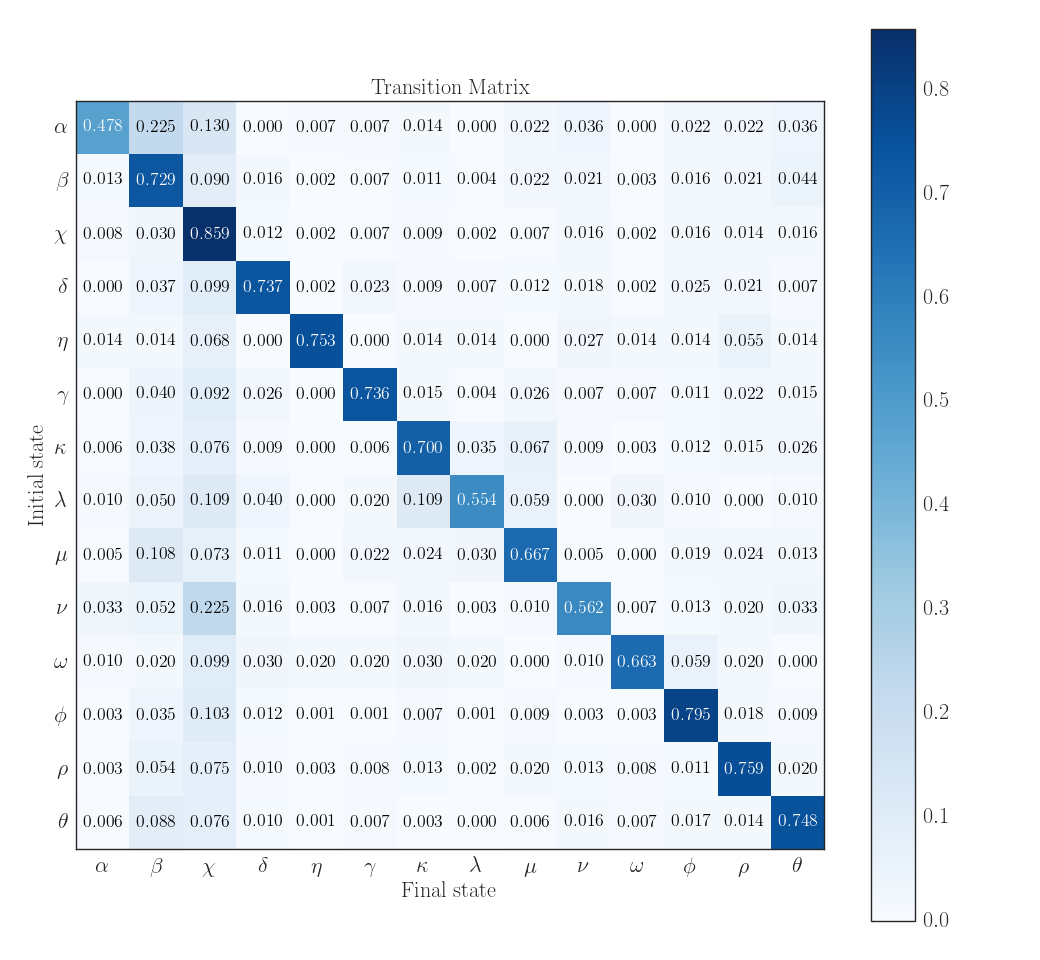

order: column
This is column
[[ 0.47826087  0.01260193  0.00803213  0.          0.01369863  0.
   0.0058309   0.00990099  0.00537634  0.03267974  0.00990099  0.00293255
   0.00327869  0.00576369]
 [ 0.22463768  0.72868792  0.03025435  0.03686636  0.01369863  0.04029304
   0.03790087  0.04950495  0.10752688  0.05228758  0.01980198  0.03519062
   0.05409836  0.08789625]
 [ 0.13043478  0.09043736  0.85917001  0.09907834  0.06849315  0.09157509
   0.07580175  0.10891089  0.07258065  0.2254902   0.0990099   0.1026393
   0.07540984  0.07636888]
 [ 0.          0.01630838  0.01204819  0.73732719  0.          0.02564103
   0.00874636  0.03960396  0.01075269  0.01633987  0.02970297  0.01173021
   0.00983607  0.01008646]
 [ 0.00724638  0.00222387  0.00160643  0.00230415  0.75342466  0.          0.
   0.          0.          0.00326797  0.01980198  0.00146628  0.00327869
   0.00144092]
 [ 0.00724638  0.00667161  0.00669344  0.02304147  0.          0.73626374
   0.0058309   0.01980198  0.02150538  

In [176]:

fig, ax = plt.subplots(1,1, figsize=(13,12))

labels_for_plotting = [r"$\%s$"%l for l in np.unique(labels_trained_full)]

fig, ax = plotting.transition_matrix(labels_trained_full, 
                                     labels_for_plotting, fig=fig, 
                                     ax=ax, log=False, order="column")
plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_transmat.pdf", format="pdf")




### Does State Rho always grow out of state Chi via State Alpha

Naik et al (2002) look at a month of data and find that class rho and alpha are always connected, and that rho grows out of the low-hard state via alpha.

Let's look at our global classification and see whether this is true.
First, let's just make the right kind of plot:

<IPython.core.display.Javascript object>


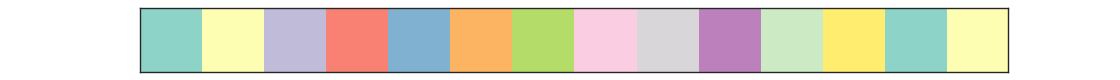

In [177]:
sns.palplot(current_palette)

<IPython.core.display.Javascript object>


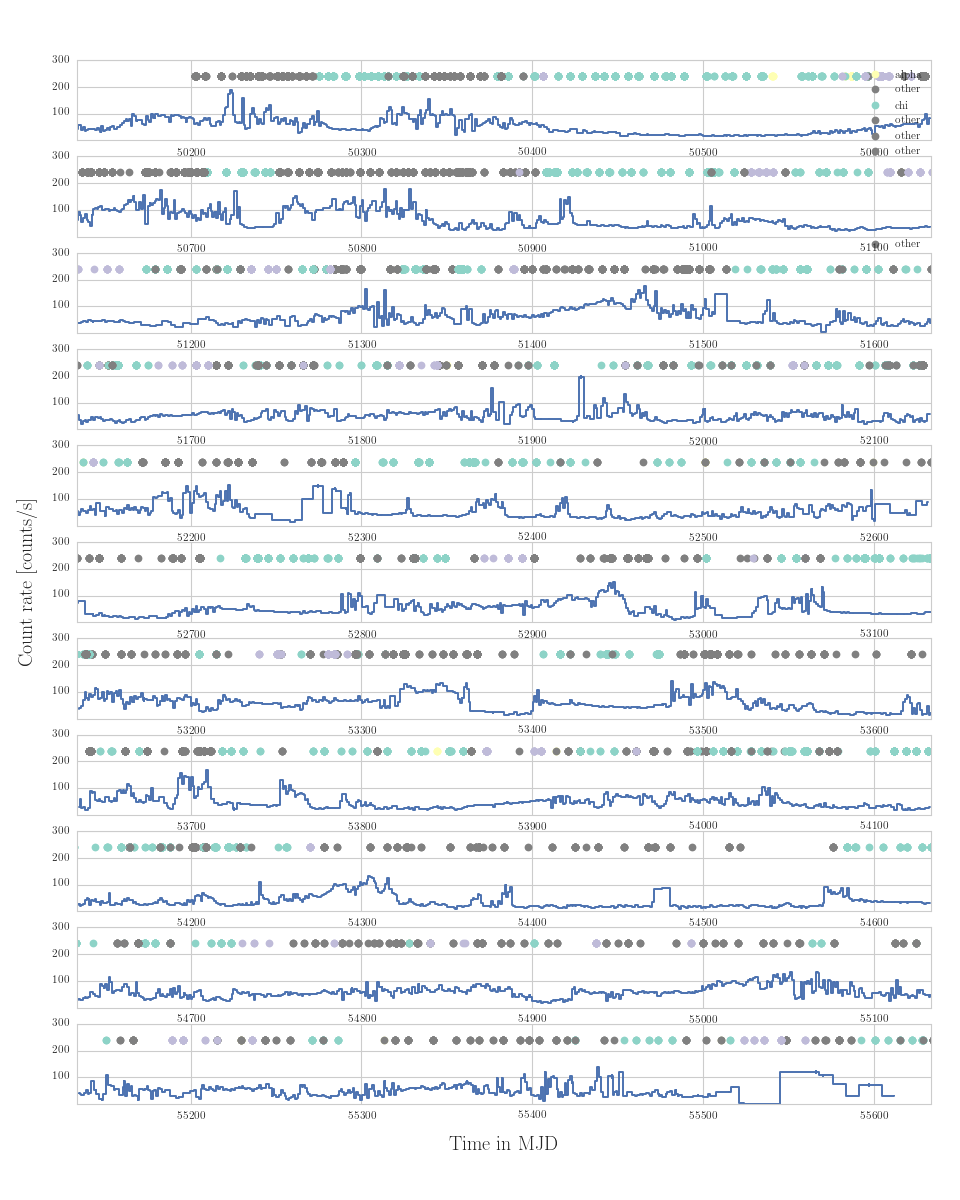

I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


In [178]:
## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len
i = 0

fig = plt.figure(figsize=(12,15))

sns.set_style("white")

ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("whitegrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)


current_palette = sns.color_palette(palette, len(unique_labels))
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    ax1 = fig.add_subplot(11,1,i+1)
    asm_s = asm[:,0].searchsorted(start_time)
    asm_e = asm[:,0].searchsorted(end_time)
    ax1.errorbar(asm[asm_s:asm_e,0], asm[asm_s:asm_e,1], 
                 yerr = asm[asm_s:asm_e,2], linestyle="steps-mid")
    for k, col in zip(unique_labels, colors):
        if k == "chi":
            c = current_palette[0]
            label = k
        elif k == "alpha":
            c = current_palette[1]
            label = k
        elif k == "rho":
            c = current_palette[2]
            label = k
        else:
            c = "grey"
            label = "other"
        tstart_members = tstart_all_mjd[labels_trained_all == k]
        #ts_s = tstart_members.searchsorted(start_time)
        #ts_e = tstart_members.searchsorted(end_time)
        ts_s = 0
        ts_e = -1
        ax1.plot(tstart_members[ts_s:ts_e], np.ones(len(tstart_members[ts_s:ts_e]))*240.,
                 "o", color=c, label=label)
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    if i == 0:
        ax1.legend()
    plt.yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1

ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

#plt.savefig(paperdir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

At first glance, it doesn't appear like alpha and rho appear always together.

Let's see if I can make a transition matrix between chi, alpha, rho and others:

In [ ]:
labels_trained_reduced = np.zeros_like(labels_trained_all)
for l in unique_labels:
    if l == "chi" or l == "alpha" or l == "rho":
        labels_trained_reduced[labels_trained_all == l] = l
    else:
        labels_trained_reduced[labels_trained_all == l] = "other"

I need a special version of the transition matrix, where we only look at transitions between alpha, rho and chi:

In [179]:
transmat = np.zeros((3,3))
for i in range(len(labels_trained_reduced)-1):
    if labels_trained_reduced[i] == "chi":
        if labels_trained_reduced[i+1] == "chi":
            transmat[0,0] += 1
        elif labels_trained_reduced[i+1] == "alpha":
            transmat[0,1] += 1
        elif labels_trained_reduced[i+1] == "rho":
            transmat[0,2] += 1
        else: continue
    elif labels_trained_reduced[i] == "alpha":
        if labels_trained_reduced[i+1] == "chi":
            transmat[1,0] += 1
        elif labels_trained_reduced[i+1] == "alpha":
            transmat[1,1] += 1
        elif labels_trained_reduced[i+1] == "rho":
            transmat[1,2] += 1
        else: continue
    elif labels_trained_reduced[i] == "rho":
        if labels_trained_reduced[i+1] == "chi":
            transmat[2,0] += 1
        elif labels_trained_reduced[i+1] == "alpha":
            transmat[2,1] += 1
        elif labels_trained_reduced[i+1] == "rho":
            transmat[2,2] += 1
        else: continue
    else: continue

            

NameError: name 'labels_trained_reduced' is not defined

In [ ]:
transmat_p = transmat/np.sum(transmat, axis=1)

In [ ]:
transmat_p

In [180]:
plt.figure()
plt.matshow(transmat_p, cmap=cmap.viridis)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [181]:
ulr, tr, transmat_r = plotting._compute_trans_matrix(labels_trained_reduced, order="row")
ulc, tc, transmat_c = plotting._compute_trans_matrix(labels_trained_reduced, order="column")
print(transmat_r)
print(transmat_c)


NameError: name 'labels_trained_reduced' is not defined

In [182]:
transmat_r1 = np.zeros_like(tr)
for i, t in enumerate(tr):
    transmat_r1[i,:] = t/np.sum(t)

NameError: name 'tr' is not defined

In [183]:
transmat_r2 = np.zeros_like(tr)
for i, t in enumerate(tr):
    transmat_r2[:,i] = tr[:,i]/np.sum(tr[:,i])

NameError: name 'tr' is not defined

In [184]:
transmat_r1

NameError: name 'transmat_r1' is not defined

In [185]:
transmat_r2

NameError: name 'transmat_r2' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
fig.subplots_adjust(left=0.15, bottom=0.15)
ax.matshow(transmat_r1, cmap=cmap.viridis)
ax.set_xticks(np.arange(len(ulr)))
ax.set_xticklabels(ulr, rotation=90)

ax.set_yticks(np.arange(len(ulr)))
ax.set_yticklabels(ulr)

plt.tight_layout()

transmat_r1

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
fig.subplots_adjust(left=0.15, bottom=0.15)
ax.matshow(transmat_r2, cmap=cmap.viridis)
ax.set_xticks(np.arange(len(ulr)))
ax.set_xticklabels(ulr, rotation=90)

ax.set_yticks(np.arange(len(ulr)))
ax.set_yticklabels(ulr)

plt.tight_layout()

transmat_r2

So from $\chi$ state, the probability of transitioning into the $\rho$ state and the $\alpha$ state is just about equal (around 1 percent). 

Same is true for arriving in those states, because the transition matrix is remarkably symmetric!


### Using the Physical Labels

What about the classification with the "physical" labels?

In [214]:
labels_train_phys = np.array(labels_phys["train"], dtype='|S16')
labels_test_phys = np.array(labels_phys["test"], dtype='|S16')
labels_val_phys = np.array(labels_phys["val"], dtype='|S16')

Note: at the moment, omega and eta are still separate classes within this scheme. 

For practical purposes, I should add them to the "None" list, so that I can check what classes they will ultimately belong to:

In [215]:
labels_train_phys[labels_train_phys == "deterministic"] = "chaotic+coloured"
labels_val_phys[labels_val_phys == "deterministic"] = "chaotic+coloured"
labels_test_phys[labels_test_phys == "deterministic"] = "chaotic+coloured"


In [216]:
labels_all_phys_withetaomega = np.hstack([labels_train_phys, labels_val_phys, labels_test_phys])

In [217]:
np.unique(labels_val_phys)

array(['None', 'chaotic', 'chaotic+coloured', 'eta', 'omega', 'stochastic'], 
      dtype='|S16')

In [218]:
unphysical = ["eta", "omega"]

for i,l in enumerate(labels_train_phys):
    if l in unphysical:
        labels_train_phys[i] = "None"

for i,l in enumerate(labels_val_phys):
    if l in unphysical:
        labels_val_phys[i] = "None"

for i,l in enumerate(labels_test_phys):
    if l in unphysical:
        labels_test_phys[i] = "None"



In [219]:
labels_unique_phys = np.unique(labels_train_phys)
print("unique physical labels: " + str(labels_unique_phys))

unique physical labels: ['None' 'chaotic' 'chaotic+coloured' 'stochastic']


In [220]:
labels_train = labels_lb["train"]
labels_test = labels_lb["test"]
labels_val = labels_lb["val"]


In [221]:
fscaled_train_phys = fscaled_train[(labels_train != "eta") & (labels_train != "omega")]
fscaled_test_phys = fscaled_test[(labels_test != "eta") & (labels_test != "omega")]
fscaled_val_phys = fscaled_val[(labels_val != "eta") & (labels_val != "omega")]

In [222]:
labels_train = labels_train_phys[labels_train_phys != "None"]
labels_test = labels_test_phys[labels_test_phys != "None"]
labels_val = labels_val_phys[labels_val_phys != "None"]

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]}#, 'max_features': }

grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, n_jobs=10)
grid.fit(fscaled_train_phys, labels_train)



Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=10)]: Done  42 out of  42 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 60, 80, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [223]:
print(grid.best_params_)
print(grid.score(fscaled_train_phys, labels_train))
print(grid.score(fscaled_val_phys, labels_val))
print(grid.score(fscaled_test_phys, labels_test))




{'n_neighbors': 1}
1.0
0.889830508475
0.951515151515


That's a pretty good performance, too.
Let's also do the Logistic Regression:

In [224]:

lr = LogisticRegression(penalty="l2", class_weight="balanced",
                       multi_class="multinomial", solver="lbfgs")

#params = {"C":[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

#grid_lr = GridSearchCV(lr, param_grid=params,
#                        verbose=0, n_jobs=10)
#grid_lr.fit(fscaled_train_phys, labels_train)
params_c =  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10.0, 20, 50, 100.0, 1000.0]

scores = np.zeros_like(params_c)
for i,c in enumerate(params_c):
    lr = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
                            C=c, solver="lbfgs")

    lr.fit(fscaled_train_phys, labels_train)
    scores[i] = lr.score(fscaled_val_phys, labels_val)




In [225]:
max_score = np.max(scores)
print(max_score)
max_ind = np.where(scores == max_score)[0][0]
print(max_ind)
lr_max_c = params_c[max_ind]
print(lr_max_c)
lr_best = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
                            C=lr_max_c, solver="lbfgs")

lr_best.fit(fscaled_train_phys, labels_train)


labels_lr = lr_best.predict(fscaled_val_phys)
labels_lr_test = lr_best.predict(fscaled_test_phys)

#labels_lr_all = lr_best.predict(fscaled_full[:,:nfeatures])
print("Test data set: " + str(lr_best.score(fscaled_test_phys, labels_test)))

0.85593220339
7
2
Test data set: 0.89696969697


This doesn't work out great. What about the linear SVC?

In [226]:
params_c =  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2, 5, 10.0, 20, 50, 100.0, 1000.0]

scores = np.zeros_like(params_c)
for i,c in enumerate(params_c):
    #lr = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
    #                        C=c, solver="lbfgs")
    svc = LinearSVC(penalty="l2", class_weight="balanced", dual=False, multi_class="crammer_singer",
                    C=c)


    svc.fit(fscaled_train_phys, labels_train)
    scores[i] = svc.score(fscaled_val_phys, labels_val)



In [227]:
max_score = np.max(scores)
print(max_score)
max_ind = np.where(scores == max_score)[0][0]
print(max_ind)
svc_max_c = params_c[max_ind]
print(svc_max_c)
svc_best = LinearSVC(penalty="l2", class_weight="balanced", dual=False, multi_class="crammer_singer",
                    C=svc_max_c)


#lr_best = LogisticRegression(penalty="l2", class_weight="balanced", multi_class="multinomial",
#                            C=lr_max_c, solver="lbfgs")

svc_best.fit(fscaled_train_phys, labels_train)


labels_svc = svc_best.predict(fscaled_val_phys)
labels_svc_test = svc_best.predict(fscaled_test_phys)

#labels_lr_all = lr_best.predict(fscaled_full[:,:nfeatures])
print("Test data set: " + str(svc_best.score(fscaled_test_phys, labels_test)))

0.881355932203
13
1000.0
Test data set: 0.886868686869


Let's try a random forest for completeness:

In [228]:
from sklearn.ensemble import RandomForestClassifier

params_max_depth = [7, 10, 20,40, 50, 100, 200, 500]
params_max_features = [2,4,6,8,10]

scores = np.zeros((len(params_max_depth), len(params_max_features)))

for i, md in enumerate(params_max_depth):
    for j, mf in enumerate(params_max_features):
        
        rfc = RandomForestClassifier(n_estimators=500, 
                                     max_features=mf, 
                                     max_depth=md)
        
        rfc.fit(fscaled_train_phys, labels_train)

        scores[i,j] = rfc.score(fscaled_val_phys, labels_val)
        
max_score = np.max(scores)
print(max_score)
max_ind = np.where(scores == max_score)

print(max_ind)
rfc_best =  RandomForestClassifier(n_estimators=500, 
                              max_depth=params_max_depth[max_ind[0][0]], 
                              max_features=params_max_features[max_ind[1][0]])

rfc_best.fit(fscaled_train_phys, labels_train)

labels_rfc = rfc_best.predict(fscaled_val_phys)
labels_rfc_test = rfc_best.predict(fscaled_test_phys)

print("Validation data set: " + str(rfc_best.score(fscaled_val_phys, labels_val)))
print("Test data set: " + str(rfc_best.score(fscaled_test_phys, labels_test)))

0.919491525424
(array([5]), array([3]))
Validation data set: 0.91313559322
Test data set: 0.927272727273


That works somewhat better! What does the confusion matrix look like for this problem?

In [229]:
cm = sklearn.metrics.confusion_matrix(labels_test, labels_rfc_test, 
                                      labels=np.unique(labels_rfc_test))

<IPython.core.display.Javascript object>


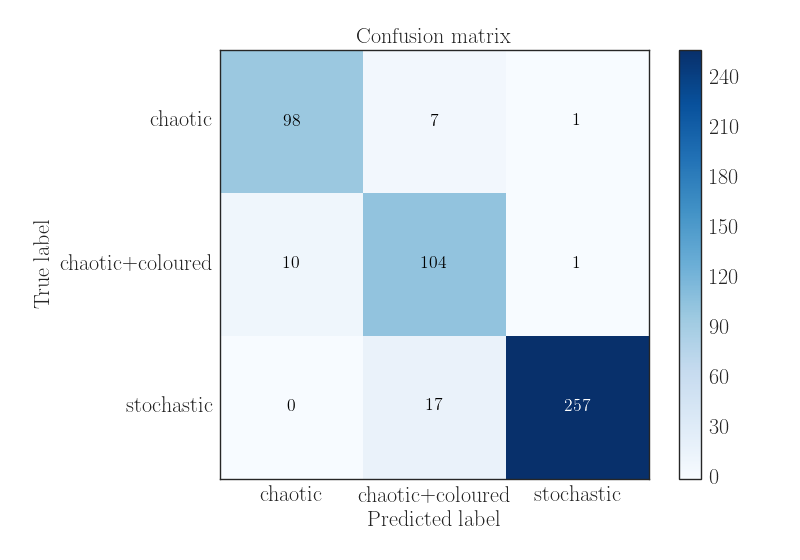

Confusion matrix, without normalization
[[ 98   7   1]
 [ 10 104   1]
 [  0  17 257]]


In [230]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
plotting.confusion_matrix(labels_test, labels_rfc_test, 
                          np.unique(labels_rfc_test), ax=ax, log=False, fig=fig,
                         cmap=cmap.Blues)

plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_phys_cm.pdf", format="pdf")



There's only very few samples confused. Let's re-do the plot with the PCA.

First, we need to classify the entire data set:

In [245]:
11./17

0.6470588235294118

In [242]:
np.sum(c)

495

In [231]:
labels_phys_full = np.hstack([labels_train_phys, labels_val_phys, labels_test_phys])

Now we can classify the entire data set:

In [232]:
fscaled_cls = fscaled_full[labels_phys_full != "None"]
fscaled_unclass = fscaled_full[labels_phys_full == "None"]
labels_cls = labels_phys_full[labels_phys_full != "None"]

labels_phys_unclass = rfc_best.predict(fscaled_unclass)
labels_phys_cls = labels_phys_full[labels_phys_full != "None"]

# make a set of labels with the human + machine labels
labels_trained_all = np.zeros_like(labels_phys_full)
labels_trained_all[labels_phys_full == "None"] = labels_phys_unclass
labels_trained_all[labels_phys_full != "None"] = labels_phys_full[labels_phys_full != "None"]

Like above, we'll look at the distributions of states:

<IPython.core.display.Javascript object>


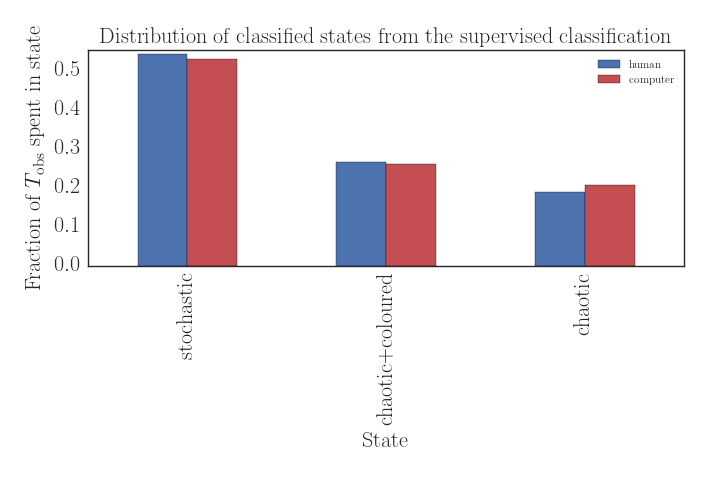

In [233]:
tstart_cls = tstart_all[labels_phys_full != "None"]

duration_cls = pd.Series(np.zeros(len(rfc_best.classes_)), index=rfc_best.classes_)
duration_unclass = pd.Series(np.zeros(len(rfc_best.classes_)), index=rfc_best.classes_)

for i,(l, ts) in enumerate(zip(labels_phys_cls, tstart_cls)):
    if i == 0:
        duration_cls.loc[l] += 1024.
    else:
        dt = ts - tstart_cls[i-1]
        if np.isclose(dt, 256.0, rtol=0.1, atol=0.1):
            duration_cls.loc[l] += 256.
        else:
            duration_cls.loc[l] += 1024.

for i,(l, ts) in enumerate(zip(labels_phys_unclass, tstart_unclass)):
    if i == 0:
        duration_unclass.loc[l] += 1024.
    else:
        dt = ts - tstart_unclass[i-1]
        if np.isclose(dt, 256.0, rtol=0.1, atol=0.1):
            duration_unclass.loc[l] += 256.
        else:
            duration_unclass.loc[l] += 1024.




durations_df = pd.concat([duration_cls, duration_unclass], axis=1)
durations_df.columns = ["human", "computer"]


durations_df /= durations_df.sum()
durations_sorted = durations_df.sort_values("human", ascending=False,)

plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 


fig, ax = plt.subplots(1,1,figsize=(9,6))
durations_sorted.plot(kind="bar", ax=ax, color=[sns.color_palette()[0], 
                                          sns.color_palette()[2]])

ax.set_ylim(0, np.max(durations_sorted.max())+0.01)
ax.set_title("Distribution of classified states from the supervised classification")
ax.set_xlabel("State")
ax.set_ylabel(r"Fraction of $T_\mathrm{obs}$ spent in state")

plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_phys_states_histogram.pdf", format="pdf")
#plt.close()




#sns.set_style("whitegrid") 
#plt.rc("font", size=24, family="serif", serif="Computer Sans")
#plt.rc("axes", titlesize=20, labelsize=20) 
#plt.rc("text", usetex=True)
#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20) 

#st = pd.Series(labels_trained_phys)
#nstates = st.value_counts()
#nstates.plot(kind='bar', color=sns.color_palette()[0])
#plt.ylim(0,1.05*np.max(nstates))
#plt.title("Distribution of classified states from the supervised classification")
#plt.savefig(datadir+"grs1915_supervised_phys_states_histogram.pdf", format="pdf")
#plt.close()



Now we're ready to re-do the PCA Figure:

In [234]:
current_palette = sns.color_palette("Set3", len(np.unique(labels_all_phys_withetaomega)))

In [235]:
colours = [current_palette[0], current_palette[1], current_palette[4]]

In [236]:
reload(plotting)

<module 'plotting' from 'plotting.pyc'>

<IPython.core.display.Javascript object>


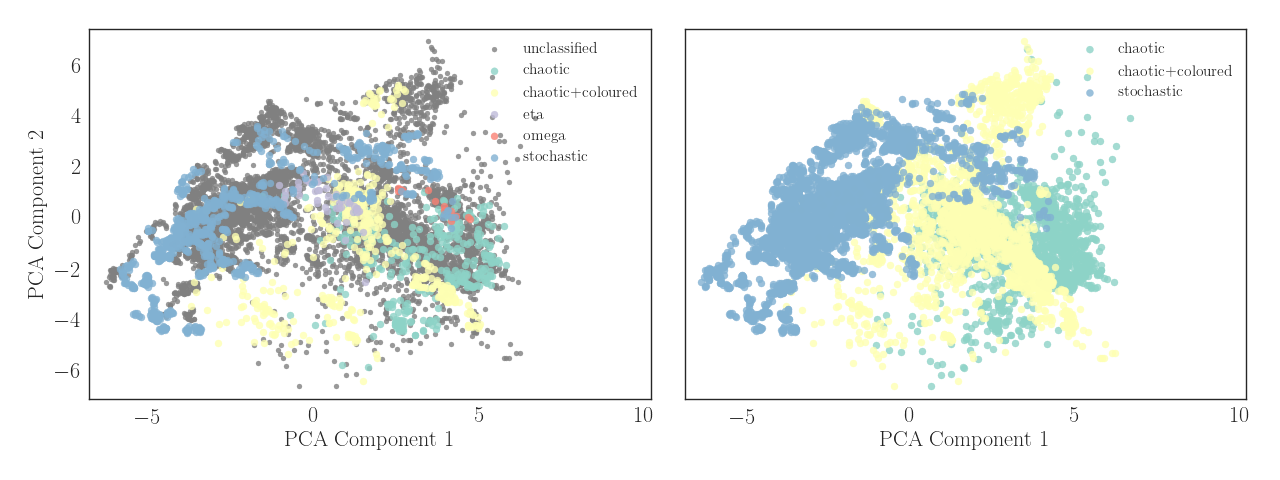

In [209]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6), sharey=True)
ax1 = plotting.scatter(fscaled_pca, labels_all_phys_withetaomega, ax=ax1)
ax2 = plotting.scatter(fscaled_pca, labels_trained_all, ax=ax2, colours=colours, ylabel=False)

axes[1].set_ylabel("")
plt.tight_layout()
plt.savefig(datadir+"sgr1915_supervised_phys_features_pca.pdf", format="pdf")
#plt.close()


Which states are eta and omega closest to?

In [237]:
labels_trained_all[labels_all_phys_withetaomega == "eta"]

array(['chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
       'chaotic+coloured', 'chaotic+coloured', 'chaotic+coloured',
    

<IPython.core.display.Javascript object>


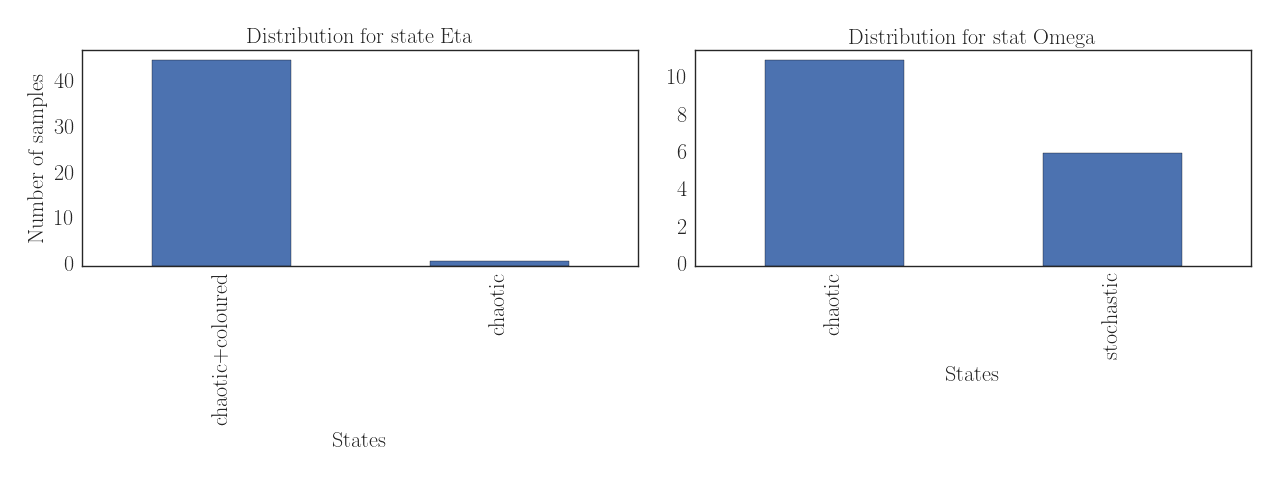

In [238]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
paper_figures.plot_eta_omega(labels_all_phys_withetaomega, labels_trained_all, axes=axes)
plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_eta_omega.pdf", format="pdf")


**Note**: I might want to repeat this experiment not with the *previously* classified light curves, but with the *newly* classified light curves in eta and omega, which should yield better results?


## Transition Matrix

I need to compute a transition matrix between states. Let's try to do that.


In [239]:
reload(plotting)

<module 'plotting' from 'plotting.pyc'>

<IPython.core.display.Javascript object>


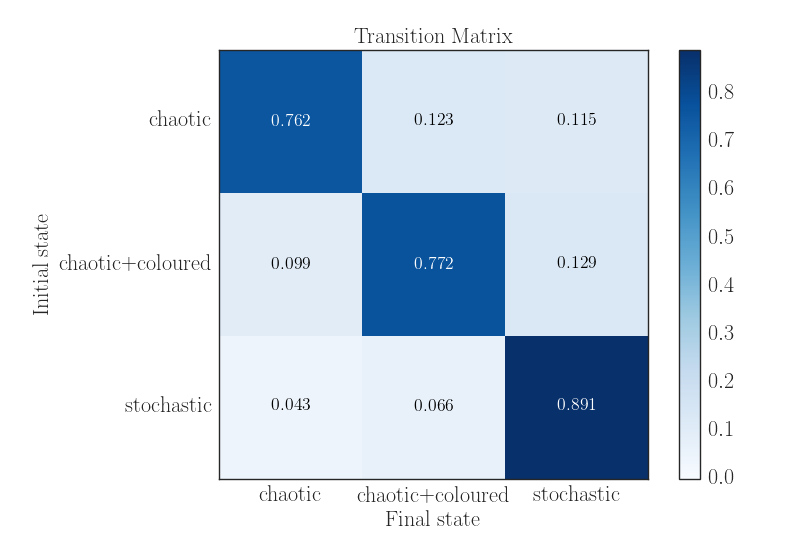

order: column
This is column
[[ 0.76177872  0.09884679  0.04290969]
 [ 0.1228163   0.77182867  0.06579485]
 [ 0.11540498  0.12932455  0.89129546]]


In [240]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax = plotting.transition_matrix(labels_trained_all, np.unique(labels_trained_all), 
                                ax=ax, log=False, fig=fig)
fig.subplots_adjust(bottom=0.15, left=0.15)
plt.tight_layout()
plt.savefig(datadir+"grs1915_supervised_phys_transmat.pdf", format="pdf")